In [2]:
#important libraries
#importing the necessary packages
import pandas as pd
import string
#import plotly.express as px
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.style

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_selection import RFE
from scipy.stats import zscore
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import statsmodels.api as sm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder,PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,log_loss,classification_report
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import plot_tree
from xgboost import XGBClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import cross_val_score

warnings.filterwarnings(action="ignore")
%matplotlib inline

#### bank client data:
1.	age (numeric)
2.	job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3.	marital : marital status (categorical: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' means divorced or widowed)
4.	education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5.	default: has credit in default? (categorical: 'no', 'yes', 'unknown')
6.	housing: has housing loan? (categorical: 'no', 'yes', 'unknown')
7.	loan: has personal loan? (categorical: 'no',' yes',' unknown')

#### related with the last contact of the current campaign:
8.	contact: contact communication type (categorical: 'cellular', 'telephone')
9.	month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10.	day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11.	duration: last contact duration, in seconds (numeric). 

#### other attributes:

12.	campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13.	pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14.	previous: number of contacts performed before this campaign and for this client (numeric)
15.	poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### social and economic context attributes
16.	emp.var.rate: employment variation rate - quarterly indicator (numeric)
17.	cons.price.idx: consumer price index - monthly indicator (numeric)
18.	cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19.	euribor3m: euribor 3 month rate - daily indicator (numeric)
20.	nr.employed: number of employees - quarterly indicator (numeric)

#### Output variable (desired target):
21.	y - has the client subscribed a term deposit? (binary: 'yes','no')

In [4]:
# Reading the original dataset:
bank_df=pd.read_csv("/Users/deepranjanguha/Desktop/Data Science /Capstone Project/Dataset/bank-additional-full.csv",sep=';')
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# Checking the shape of the dataset:
bank_df.shape

(41188, 21)

In [6]:
# Let us replace our target variable with binary values 0 and 1
bank_df['y']=bank_df['y'].replace(['yes','no'],[1,0])
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [7]:
# Segregating the continuous and categorical cariables.
df_numerical=bank_df.select_dtypes(np.number)
df_categorical=bank_df.select_dtypes(object)

In [8]:
# dropping the target variable from the dataframe:
df_numerical=df_numerical.drop('y',axis=1)
df_numerical.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0


In [9]:
df_categorical.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent


# Predictive Modeling

### Basic Visualizations to understand the data.

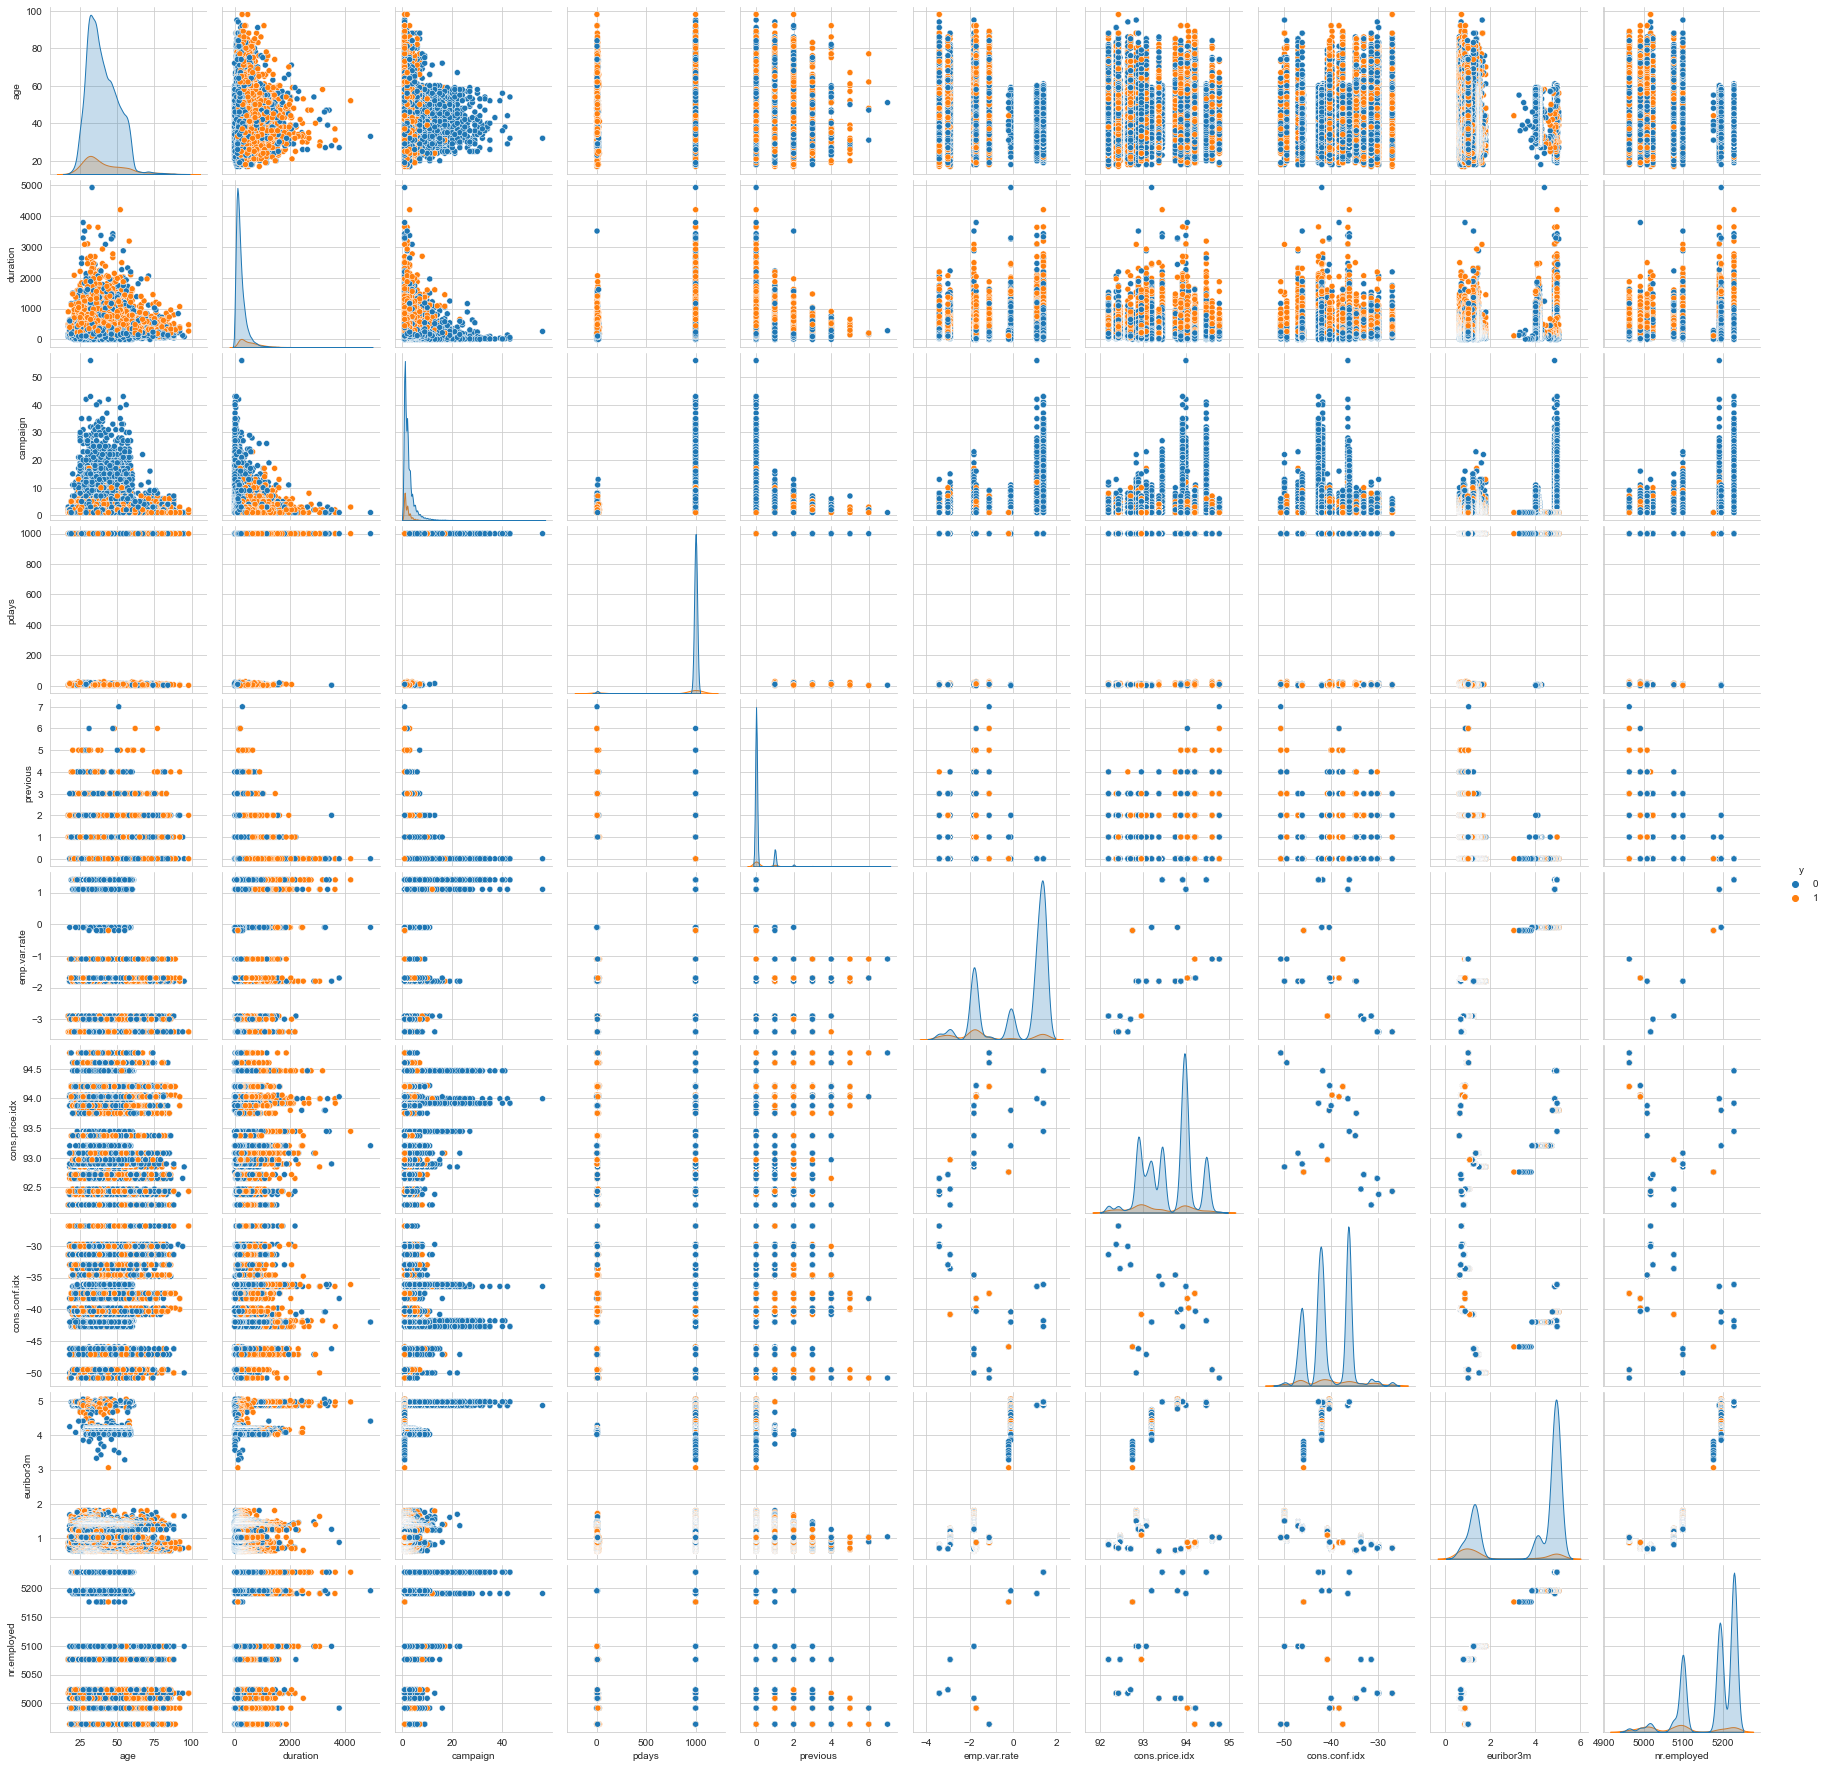

In [9]:
#starting with the pair plot
sns.set_style('whitegrid')
sns.pairplot(data=bank_df,hue='y')

<AxesSubplot:>

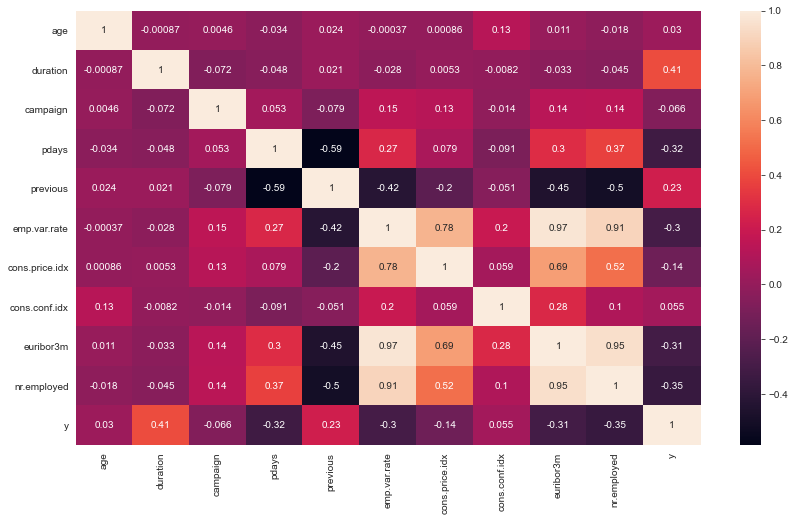

In [10]:
# Checking the correlation matrix :
plt.figure(figsize=(14,8))
sns.heatmap(bank_df.corr(),annot=True)

#### Inference: We can see that multicollinearity exists.

# Outliers Detection And Treatment for Numerical variables:

In [10]:
# Checking the outliers by its skweness
df_numerical.skew()

age               0.784697
duration          3.263141
campaign          4.762507
pdays            -4.922190
previous          3.832042
emp.var.rate     -0.724096
cons.price.idx   -0.230888
cons.conf.idx     0.303180
euribor3m        -0.709188
nr.employed      -1.044262
dtype: float64

# Graphical Representation of Outliers :

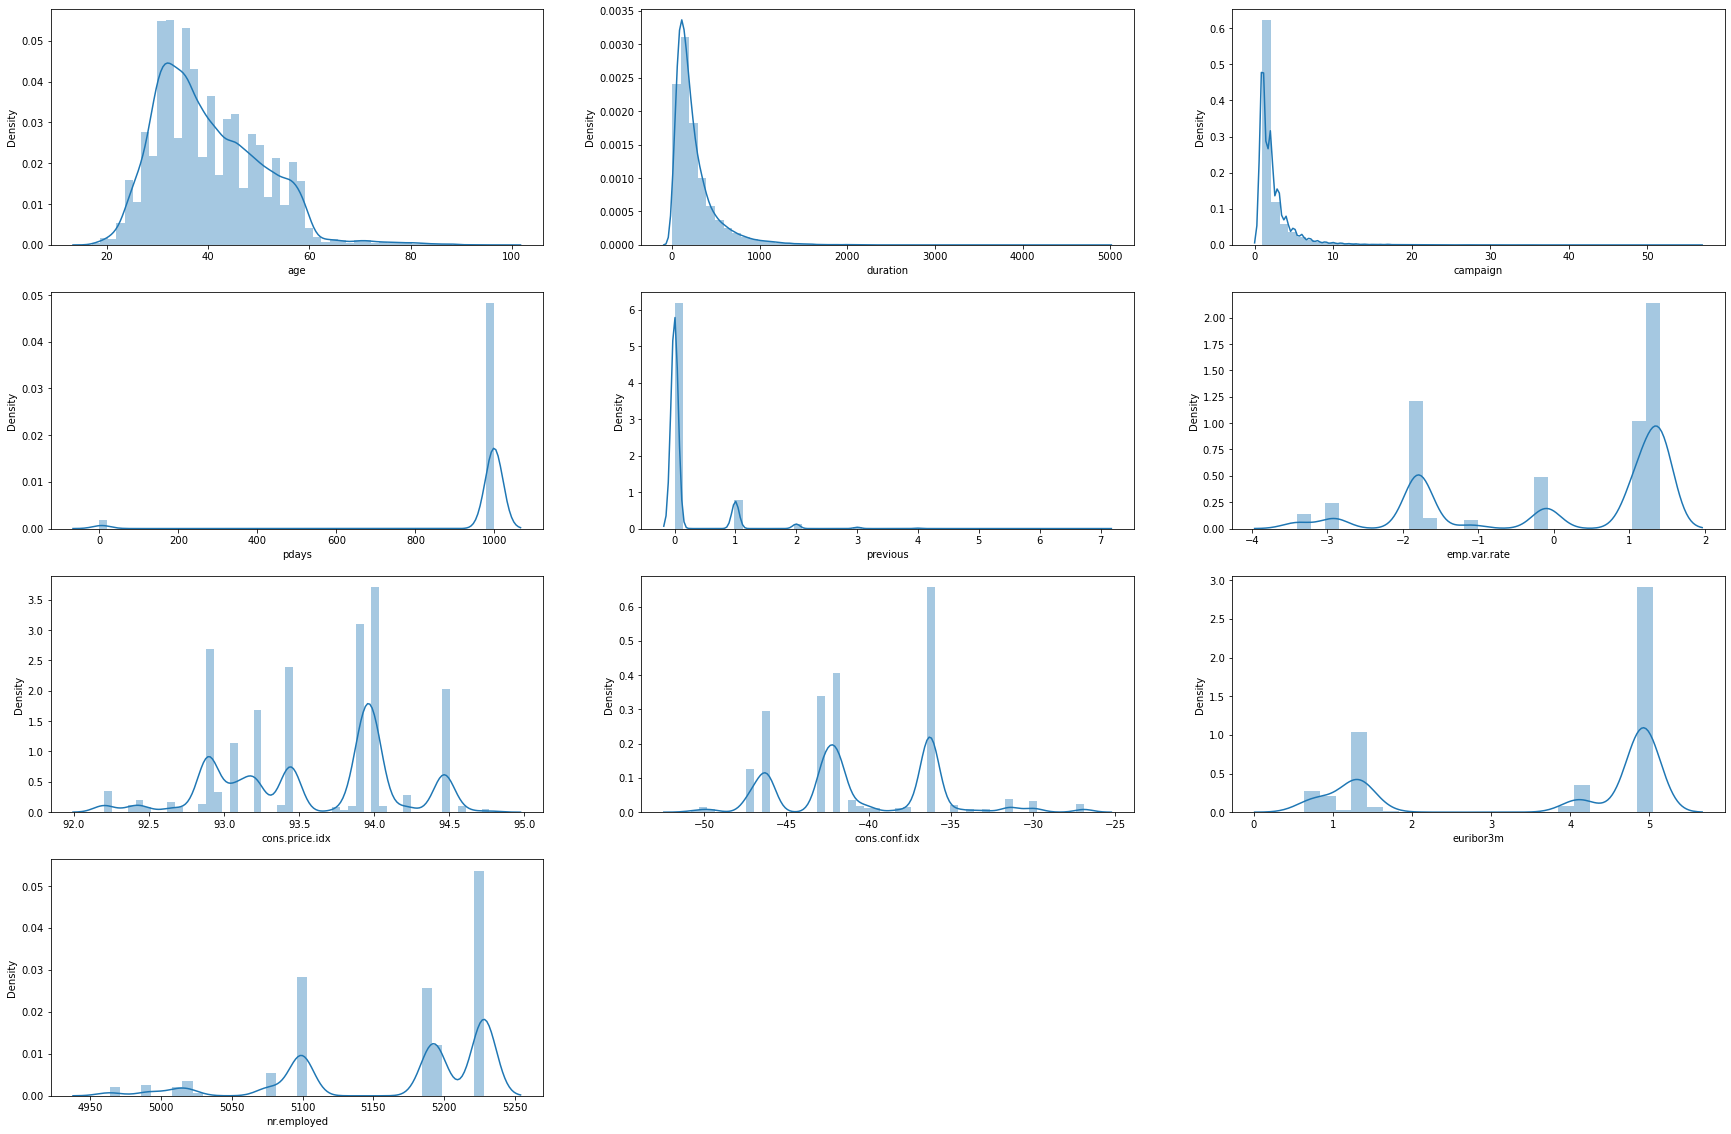

In [11]:
plt.figure(figsize=(30,20))
s=1
for p in df_numerical:
    plt.subplot(4,3,s)
    sns.distplot(df_numerical[p])
    s+=1

# Feature Scaling/Transformation:

# Treatment of Outliers by Powertransformation :

In [12]:
pt=PowerTransformer()
bank_pwrtransformed_data_num=pd.DataFrame(pt.fit_transform(df_numerical),columns=df_numerical.columns)
bank_pwrtransformed_data_num.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.427459,0.389913,-1.045497,0.195415,-0.397706,0.561017,0.700791,0.911782,0.71366,0.140827
1,1.492292,-0.234770,-1.045497,0.195415,-0.397706,0.561017,0.700791,0.911782,0.71366,0.140827
2,-0.158076,0.225113,-1.045497,0.195415,-0.397706,0.561017,0.700791,0.911782,0.71366,0.140827
3,0.150155,-0.220434,-1.045497,0.195415,-0.397706,0.561017,0.700791,0.911782,0.71366,0.140827
4,1.427459,0.579397,-1.045497,0.195415,-0.397706,0.561017,0.700791,0.911782,0.71366,0.140827


In [13]:
# Checking the outliers by its skweness after power transformation:
bank_pwrtransformed_data_num.skew()

age               0.007336
duration          0.016940
campaign          0.268430
pdays            -4.922068
previous          2.116794
emp.var.rate     -0.414214
cons.price.idx   -0.038410
cons.conf.idx     0.047975
euribor3m        -0.649814
nr.employed      -0.502649
dtype: float64

Hence we have reduced the effect of outltiers and have prepared the final dataset for Predictive modelling.

# Graphical Representation after Outlier Treatment :

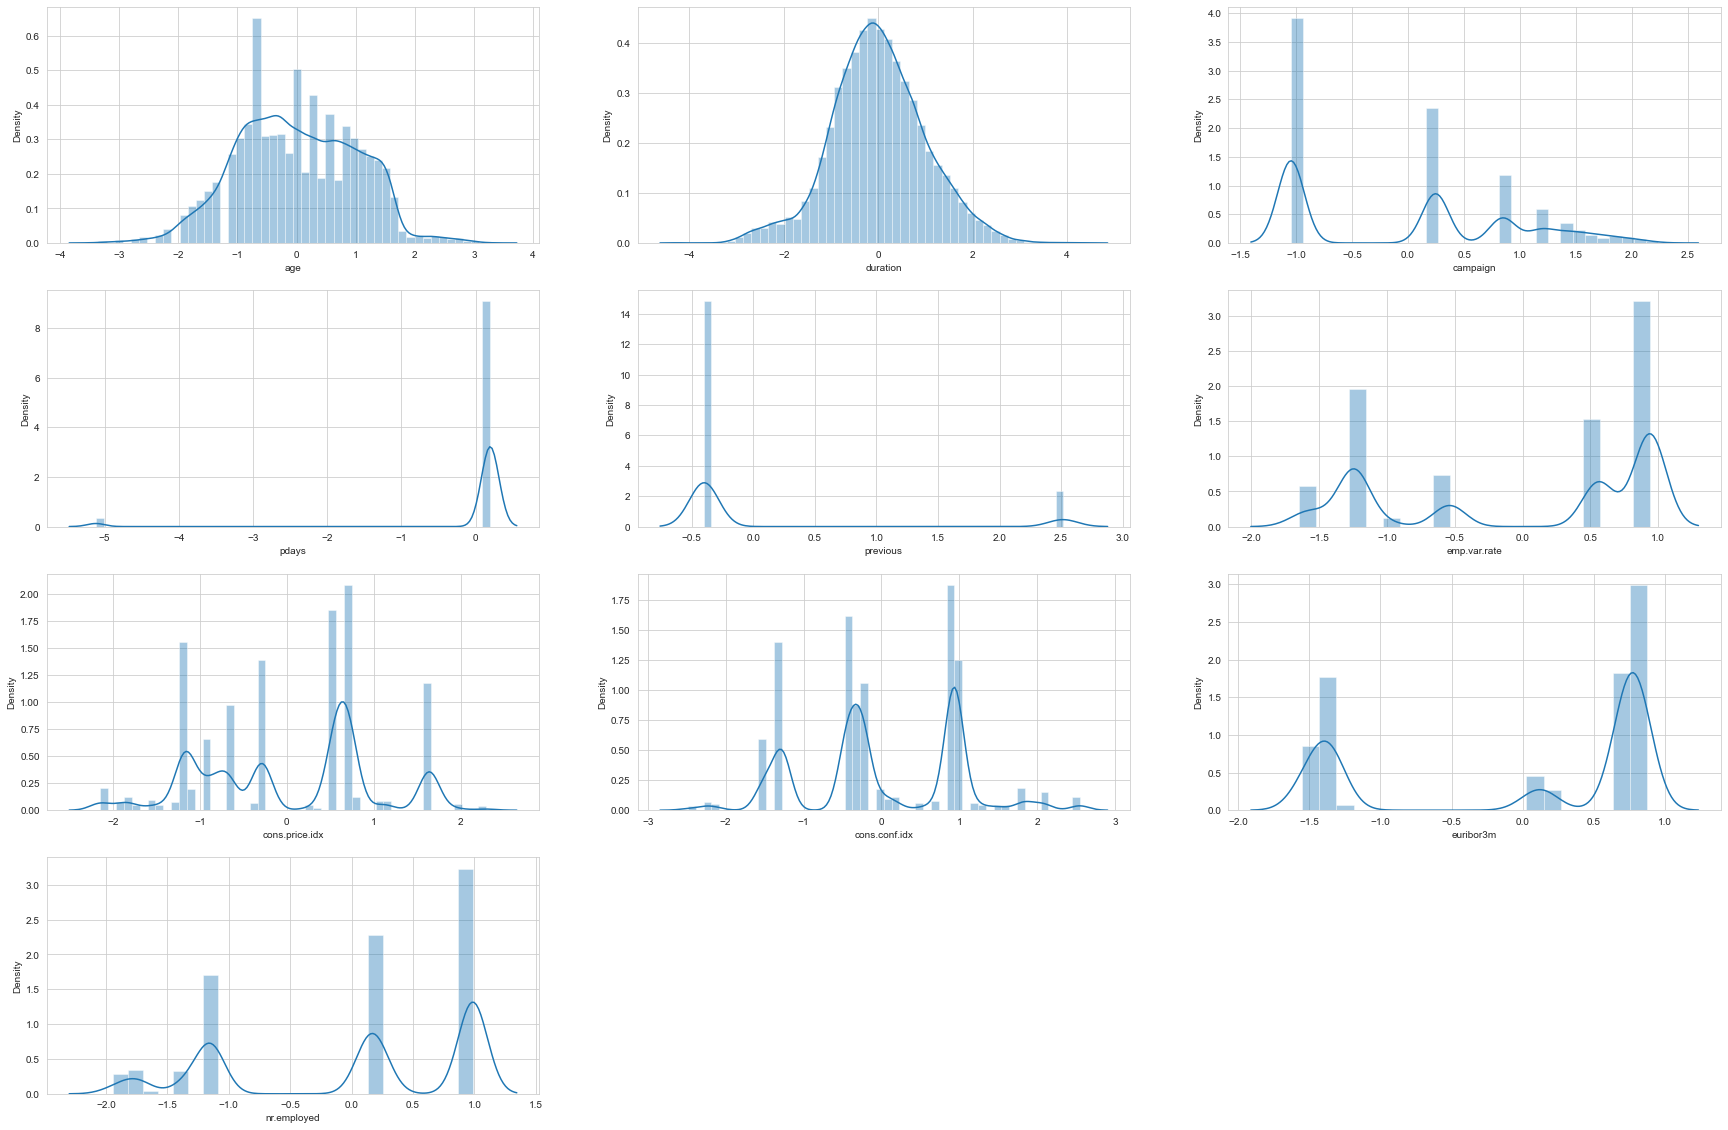

In [16]:
plt
plt.figure(figsize=(30,20))
s=1
for p in bank_pwrtransformed_data_num:
    plt.subplot(4,3,s)
    sns.distplot(bank_pwrtransformed_data_num[p])
    s+=1

# Logit Model analysis:

#### Seperating the target variable and the dependent variables:

In [14]:
# Dependent variables:
X=bank_pwrtransformed_data_num

# Target variable:
y=bank_df[['y']].reset_index(drop=True)

#### Encoding the categorical variables:

In [15]:
Encode=pd.get_dummies(data=df_categorical,drop_first=True)

# Concatenating the Encoded categorical attributes to the powertransformed numerical attributes:
X=pd.concat([pd.DataFrame(X),Encode],axis=1)

# Feature Engineeering:

#### Removing features involved in multicollinearity uisng Variance Inflation Factor:

In [16]:
 for i in range(len(X.columns)):
    vif=pd.DataFrame()
    vif['VIF Factor']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['Features']=X.columns
    multi=vif[vif['VIF Factor']>10]
    if (multi.empty==False):
        bank_df_sorted=multi.sort_values(by='VIF Factor',ascending=False)
    else:
        print(vif)
        break
    if (bank_df_sorted.empty==False):
        X=X.drop(bank_df_sorted['Features'].iloc[0],axis=1)
    else:
        print(vif)

    VIF Factor                       Features
0     1.597147                            age
1     1.034927                       duration
2     1.049380                       campaign
3     1.588435                       previous
4     3.425051                 cons.price.idx
5     2.072703                  cons.conf.idx
6     3.978334                    nr.employed
7     2.739380                job_blue-collar
8     1.159562               job_entrepreneur
9     1.158598                  job_housemaid
10    1.323663                 job_management
11    1.412815                    job_retired
12    1.145820              job_self-employed
13    1.527863                   job_services
14    1.230786                    job_student
15    2.036574                 job_technician
16    1.112942                 job_unemployed
17    1.079085                    job_unknown
18    5.696048                marital_married
19    3.635407                 marital_single
20    1.020712                mari

In [17]:
X.head()

,age,duration,campaign,previous,cons.price.idx,cons.conf.idx,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_success
0,1.427459,0.389913,-1.045497,-0.397706,0.700791,0.911782,0.140827,0,0,1,...,0,1,0,0,0,1,0,0,0,0
1,1.492292,-0.234770,-1.045497,-0.397706,0.700791,0.911782,0.140827,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,-0.158076,0.225113,-1.045497,-0.397706,0.700791,0.911782,0.140827,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0.150155,-0.220434,-1.045497,-0.397706,0.700791,0.911782,0.140827,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,1.427459,0.579397,-1.045497,-0.397706,0.700791,0.911782,0.140827,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [18]:
# Checking the shape of the dependent dataset
X.shape

(41188, 48)

#### Splitting the data into training and testing set in the ratio (80:20):

In [19]:
rc=10      # Initialising the random state at 10.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=rc)

In [57]:
###################################################################################################

## Logit model summary for full model:

In [334]:
# using statsmodels:
X_train_const=sm.add_constant(X_train)
logit_model=sm.Logit(y_train,X_train_const).fit()
logit_model.summary()

         Current function value: 0.194564
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                32950
Model:                          Logit   Df Residuals:                    32901
Method:                           MLE   Df Model:                           48
Date:                Wed, 20 Oct 2021   Pseudo R-squ.:                  0.4473
Time:                        16:27:52   Log-Likelihood:                -6410.9
converged:                      False   LL-Null:                       -11599.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -3.7327      0.166    -22.421      0.000      -4.059      -3.406
age                              -0.0541      0.029     -1.871      0.061      -0.111       0.003
duration                          1.8577      0.032     58.185      0.000       1.795       1.920
campaign                         -0.0921      0.025     -3.640      0.000      -0.142      -0.042
previous                         -0.1355      0.025     -5.475      0.000      -0.184      -0.087
cons.price.idx                    0.0663      0.030      2.247      0.025       0.008       0.124
cons.conf.idx                     0.1258      0.028      4.512      0.000       0.071       0.180
nr.employed                      -1.1888      0.035    -33.650      0.000      -1.258      -1.120
job_blue-collar                  -0.2335      0.090     -2.588      0.010      -0.410      -0.057
job_entrepreneur                 -0.0702      0.138     -0.508      0.611      -0.341       0.201
job_housemaid                     0.0851      0.165      0.515      0.607      -0.239       0.409
job_management                   -0.0994      0.097     -1.020      0.308      -0.290       0.092
job_retired                       0.3881      0.117      3.313      0.001       0.159       0.618
job_self-employed                -0.1164      0.134     -0.867      0.386      -0.379       0.147
job_services                     -0.2204      0.098     -2.250      0.024      -0.412      -0.028
job_student                       0.1592      0.136      1.173      0.241      -0.107       0.425
job_technician                    0.0143      0.081      0.176      0.860      -0.145       0.173
job_unemployed                    0.0403      0.150      0.268      0.789      -0.255       0.335
job_unknown                       0.1548      0.273      0.566      0.571      -0.381       0.691
marital_married                   0.0214      0.078      0.274      0.784      -0.132       0.175
marital_single                    0.0392      0.090      0.437      0.662      -0.137       0.215
marital_unknown                   0.1354      0.440      0.307      0.759      -0.728       0.998
education_basic.6y                0.1335      0.135      0.987      0.324      -0.132       0.399
education_basic.9y               -0.0196      0.106     -0.184      0.854      -0.228       0.189
education_high.school            -0.0064      0.104     -0.062      0.951      -0.210       0.197
education_illiterate              1.5637      0.858      1.822      0.068      -0.118       3.246
education_professional.course     0.0316      0.115      0.274      0.784      -0.194       0.258
education_university.degree       0.1664      0.104      1.594      0.111      -0.038       0.371
education_unknown                 0.1294      0.136      0.948      0.343      -0.138       0.397
default_unknown                  -0.2864      0.074     -3.884      0.000      -0.431      -0.142
default

# Statistical Analysis of the features:

#### Significant features affecting the model:

In [335]:
# If the p value for Wald test statistic is less than 0.05, we are considering the feature to be significant.
significant=logit_model.pvalues[logit_model.pvalues<0.05]
significant_features=pd.DataFrame(data=significant,columns=['p-value'])
significant_features.drop('const',axis=0)

,p-value
duration,0.000000e+00
campaign,2.727835e-04
previous,4.387419e-08
cons.price.idx,2.463176e-02
cons.conf.idx,6.412712e-06
nr.employed,3.095202e-248
job_blue-collar,9.657857e-03
job_retired,9.214482e-04
job_services,2.443395e-02
default_unknown,1.028651e-04


The following dependent variables contribute significantly to the overall model performance:

* duration
* campaign
* previous
* cons.price.idx
* cons.conf.idx
* nr.employed
* job_blue-collar
* job_retired
* job_services
* default_unknown
* contact_telephone
* month_aug
* month_dec
* month_jul
* month_jun
* month_mar
* month_may
* month_oct
* poutcome_success

#### Log odds value for each feature:

In [336]:
log_odds=round(logit_model.params,2)
log_odds_data=pd.DataFrame(log_odds,columns=['Log odds'])
log_odds_data.drop('const',axis=0)

,Log odds
age,-0.05
duration,1.86
campaign,-0.09
previous,-0.14
cons.price.idx,0.07
cons.conf.idx,0.13
nr.employed,-1.19
job_blue-collar,-0.23
job_entrepreneur,-0.07
job_housemaid,0.09


#### Odds Value for each feature:
    

In [337]:
odds=round(np.exp(logit_model.params),2)
odds_data=pd.DataFrame(odds,columns=['Odds value'])
odds_data.sort_values(by='Odds value',ascending=False).drop('const',axis=0)

,Odds value
poutcome_success,6.90
month_mar,6.63
duration,6.41
education_illiterate,4.78
month_jun,2.12
month_jul,2.10
month_aug,1.90
month_oct,1.78
month_dec,1.66
job_retired,1.47


In [32]:
# Higher the odds value, greater is the relation of the feature with the target variable.

#### Model Evaluation : McFadden's R^2 value(Pseudo R^2)


In [338]:
accuracy=logit_model.prsquared
print('Logit model accuracy : ',accuracy)

Logit model accuracy :  0.44731193954633286


# Model Performance:

## Accuracy using Confusion Matrix:

#### Considering the probability threshold to be 0.5:

In [ ]:
# Initializing the probability threshold:
th=0.5
ypred_prob=logit_model.predict(X_test)
ypred=[0 if p<th else 1 for p in ypred_prob]

# Computing the Confusion matrix:
confusion_mat=confusion_matrix(y_test,ypred)
tn = confusion_mat[0,0]
tp = confusion_mat[1,1]
fp = confusion_mat[0,1]
fn = confusion_mat[1,0]
print('Confusion Matrix for Logit Model : ')
print('---------------------------------','\n')
print(confusion_mat)

#### Graphical Representation of Confusion Matrix:

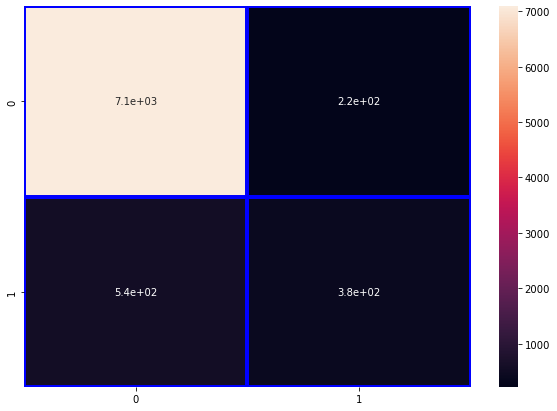

In [251]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_mat,annot=True,linewidth=3.5,linecolor='blue')
plt.show()

#### Calculating optimal value threshold for full model using the Youden's index:

In [252]:
# Computing the True Positive rate(TPR),False Positive rate(FPR) and probability threshold:
fpr, tpr, th= roc_curve(y_test, ypred_prob)

# Creating a Dataframe of the data:
youden= pd.DataFrame({'TPR': tpr,
                       'FPR': fpr,
                        'thres':th})

# Calculating the Younden's index:
youden['YI']= youden.TPR-youden.FPR
youden= youden.sort_values(by='YI',ascending=False).reset_index(drop=True)
print(youden.head(5))
print('-----------------------------------------','\n')
# or
print('Optimal threshold for probability: ',round(youden['YI'].max(),2))

        TPR       FPR     thres        YI
0  0.898707  0.151710  0.110695  0.746997
1  0.899784  0.152804  0.109174  0.746980
2  0.900862  0.153899  0.108453  0.746963
3  0.897629  0.151300  0.111410  0.746330
4  0.896552  0.150616  0.111762  0.745936
----------------------------------------- 

Optimal threshold for probability:  0.75


#### Considering the Optimal probability threshold:

In [253]:
# Initialising the optimal probability threshold:
opt_th=0.75
ypred_prob=logit_model.predict(X_test)
ypred_optimal=[0 if p<opt_th else 1 for p in ypred_prob]

# Computing the Confusion matrix:
confusion_mat_optimal=confusion_matrix(y_test,ypred_optimal)
tn = confusion_mat_optimal[0,0]
tp = confusion_mat_optimal[1,1]
fp = confusion_mat_optimal[0,1]
fn = confusion_mat_optimal[1,0]
print('Confusion Matrix from Logit Model : ')
print('------------------------------------','\n')
print(confusion_mat_optimal)

Confusion Matrix from Logit Model : 
------------------------------------ 

[[7225   85]
 [ 732  196]]


#### Graphical Representation of Confusion Matrix:

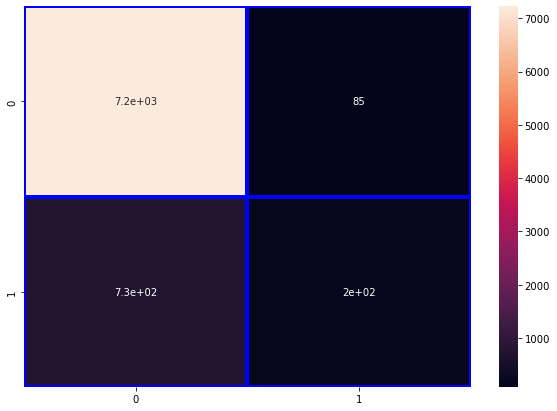

In [254]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_mat_optimal,annot=True,linewidth=3.5,linecolor='blue')
plt.show()

#### Logit model accuracy from confusion matrix :

In [255]:
# For probability threshold as 0.5:
logit_model_accuracy_test=accuracy_score(y_test,ypred)
print('Logit model accuracy for test data using confusion matrix : ',logit_model_accuracy_test)

Logit model accuracy for test data using confusion matrix :  0.9071376547705754


In [256]:
# For optimal probability threshold as 0.75:
logit_model_optimal_accuracy=accuracy_score(y_test,ypred_optimal)
print('Logit model accuracy using confusion matrix : ',logit_model_optimal_accuracy)

Logit model accuracy using confusion matrix :  0.900825443068706


In [41]:
# Hence we will be considering 0.5 as the threshold as it gives a slightly better overall accuracy.

#### Logit model classification report:

In [257]:
# Computing the classification report:

logit_classification=classification_report(y_test,ypred)
print('Logit model classification report: ')
print('------------------------------------','\n')
print(logit_classification)

Logit model classification report: 
------------------------------------ 

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7310
           1       0.63      0.41      0.50       928

    accuracy                           0.91      8238
   macro avg       0.78      0.69      0.72      8238
weighted avg       0.90      0.91      0.90      8238



In [56]:
###################################################################################################

# 1. Logistic Regression Model using Scikit-learn:

In [258]:
# Logistic Regression Model using sklearn:
log_reg=LogisticRegression()
log_model=log_reg.fit(X_train,y_train)
ypred_lr_test=log_model.predict(X_test)
ypred_lr_train=log_model.predict(X_train)
ypred_lr_probability=log_model.predict_proba(X_test)[:,1]

## 1.a) Model Performance Evaluation:

#### 1.a).1.  Confusion Matrix for Logistic Regression Model:

In [259]:
# Computing the Confusion matrix: 

confusion_mat=confusion_matrix(y_test,ypred_lr_test)
tn = confusion_mat[0,0]
tp = confusion_mat[1,1]
fp = confusion_mat[0,1]
fn = confusion_mat[1,0]
print('Confusion Matrix form Logistic Regression Model : ')
print('------------------------------------------------','\n')
print(confusion_mat)

Confusion Matrix form Logistic Regression Model : 
------------------------------------------------ 

[[7089  221]
 [ 546  382]]


#### 1.a).2.  Graphical Representation of Confusion Matrix:

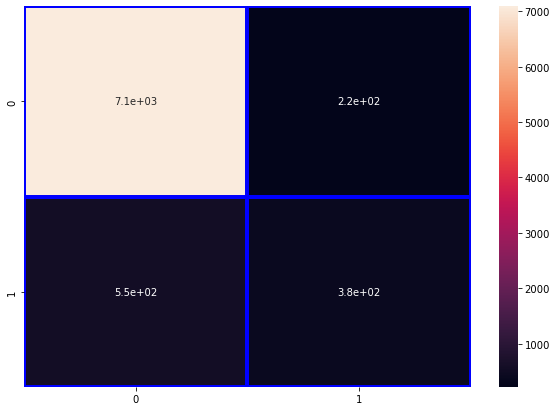

In [120]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_mat,annot=True,linewidth=3.5,linecolor='blue')
plt.show()

#### Sensitivity and Specificity:

In [121]:
Sensitivity_Logistic=(tp/(tp+fn))
print('Sensitivity of the Logistic Regression Model: ')
print('---------------------------------------------','\n')
print(Sensitivity_Logistic)
print('\n')
Specificity_Logistic=(tn/(tn+fp))
print('Specificity of the Logistic Regression Model: ')
print('---------------------------------------------','\n')
print(Specificity_Logistic)

Sensitivity of the Logistic Regression Model: 
--------------------------------------------- 

0.41163793103448276


Specificity of the Logistic Regression Model: 
--------------------------------------------- 

0.9697674418604652


#### 1.a).3.  Accuracy Analysis:

In [122]:
print('The Accuracy score of the test data for Logistic Regression model : ')
print(accuracy_score(y_test,ypred_lr_test),'\n')
print('The Accuracy score of the train data for Logistic Regression model : ')
print(accuracy_score(y_train,ypred_lr_train))

The Accuracy score of the test data for Logistic Regression model : 
0.9068948773974266 

The Accuracy score of the train data for Logistic Regression model : 
0.9130197268588771


#### 1.a).4. Logistic Regression model classification report:

In [123]:
# Computing the classification report:

logistic_report=classification_report(y_test,ypred_lr_test)
print('Logit model classification report: ')
print('------------------------------------','\n')
print(logistic_report)

Logit model classification report: 
------------------------------------ 

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7310
           1       0.63      0.41      0.50       928

    accuracy                           0.91      8238
   macro avg       0.78      0.69      0.72      8238
weighted avg       0.90      0.91      0.90      8238



#### 1.a).5. ROC Curve for Logistic Regression Model:

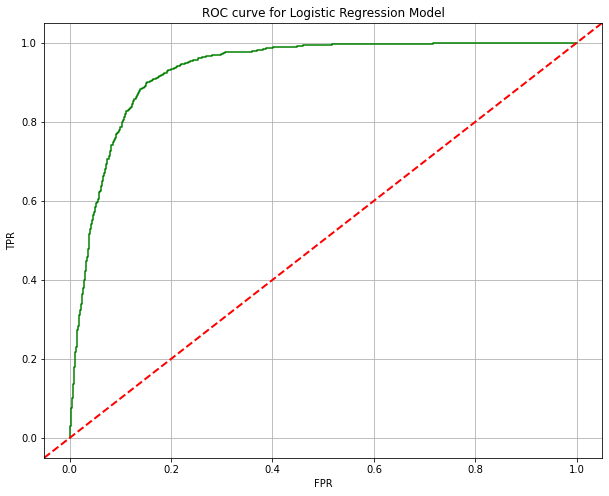

In [383]:
fpr,tpr,th=roc_curve(y_test,ypred_lr_probability)
plt.figure(figsize=(10,8))
plt.plot(fpr,tpr,color='green')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.title('ROC curve for Logistic Regression Model')
plt.plot([-0.05,1.05],[-0.05,1.05],'r--',linewidth=2)
plt.show()

#### 1.a).6. ROC AUC Score:

In [125]:
print('The ROC AUC score of the Logistic Regression model: ')
print('--------------------------------------------------- ','\n')
print('ROC AUC : ',roc_auc_score(y_test,ypred_lr_probability))

The ROC AUC score of the Logistic Regression model: 
---------------------------------------------------  

ROC AUC :  0.9315539648096609


#### 1.a).7. Cross Entropy:

In [126]:
cross_entropy=log_loss(y_test,ypred_lr_test)
print('The Cross Entropy score of the Logistic Regression model ')
print('--------------------------------------------------- ','\n')
print('Cross Entropy : ',cross_entropy)

The Cross Entropy score of the Logistic Regression model 
---------------------------------------------------  

Cross Entropy :  3.2157584615111157


#### 1.a).8. Bias Error and Variance Error:

In [127]:
k=KFold(n_splits=10,shuffle=True, random_state=10)
scores=cross_val_score(estimator=log_model,X=X_train,y=y_train,cv=k,scoring='accuracy')
print("Mean Score : ",np.mean(scores))
print("Bias error : ",(1-np.mean(scores))*100)
print("Variance error : ",(np.std(scores)/np.mean(scores))*100,'\n')

Mean Score :  0.9120485584218514
Bias error :  8.79514415781486
Variance error :  0.35553601461980733 



## 1.b) Inferences for Logistic Regression Model:

* Cross Entropy for the Logistic Regression Model is 3.17


* ROC AUC Score for the Logistic Regression Model is 93.28


* The Model Accuracy for the Logistic Regression Model is coming out to be around 91%.


* f1 weighted avg for the Logistic Regression Model is around 90%.


* Specificity : 97%


* Sensitivity : 42%


In [ ]:
###################################################################################################

# 2. K-Nearest Neighbors Classification Model using Scikit-learn:

In [128]:
# Classification Model using sklearn:
knn_algorithm=KNeighborsClassifier()
knn_model=knn_algorithm.fit(X_train,y_train)
ypred_knn_test=knn_model.predict(X_test)
ypred_knn_train=knn_model.predict(X_train)
ypred_probability_knn=knn_model.predict_proba(X_test)[:,1]

## 2.a) Model Performance Evaluation:

#### 2.a).1. Confusion Matrix for K-Nearest Neighbors Model:

In [129]:
# Computing the Confusion matrix:

knn_confusion_mat=confusion_matrix(y_test,ypred_knn_test)
tn = knn_confusion_mat[0,0]
tp = knn_confusion_mat[1,1]
fp = knn_confusion_mat[0,1]
fn = knn_confusion_mat[1,0]
print('Confusion Matrix for K-Nearest Neighbors Model : ')
print('------------------------------------------------','\n')
print(knn_confusion_mat)

Confusion Matrix for K-Nearest Neighbors Model : 
------------------------------------------------ 

[[7059  251]
 [ 572  356]]


#### 2.a).2.  Graphical Representation of Confusion Matrix:

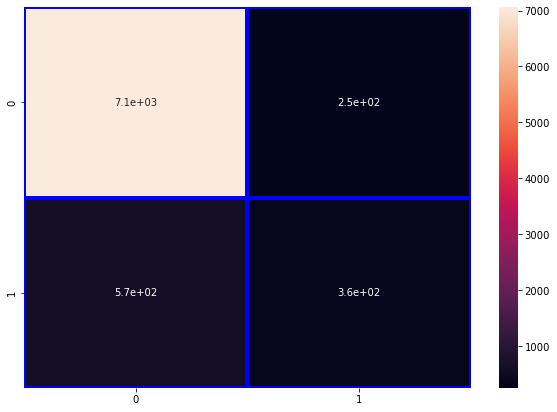

In [130]:
plt.figure(figsize=(10,7))
sns.heatmap(knn_confusion_mat,annot=True,linewidth=3.5,linecolor='blue')
plt.show()

#### Sensitivity and Specificity:

In [131]:
Sensitivity_KNN=(tp/(tp+fn))
print('Sensitivity of the KNN Model: ')
print('---------------------------------------------','\n')
print(Sensitivity_KNN)
print('\n')
Specificity_KNN=(tn/(tn+fp))
print('Specificity of the KNN Model: ')
print('---------------------------------------------','\n')
print(Specificity_KNN)

Sensitivity of the KNN Model: 
--------------------------------------------- 

0.38362068965517243


Specificity of the KNN Model: 
--------------------------------------------- 

0.9656634746922025


#### 2.a).3. Accuracy Analysis:

In [132]:
print('The Accuracy score of the test data for K-Nearest Neighbors Model : ')
print(accuracy_score(y_test,ypred_knn_test),'\n')
print('The Accuracy score of the train data for K-Nearest Neighbors Model : ')
print(accuracy_score(y_train,ypred_knn_train))

The Accuracy score of the test data for K-Nearest Neighbors Model : 
0.9000971109492595 

The Accuracy score of the train data for K-Nearest Neighbors Model : 
0.9298634294385433


#### 2.a).4. K-Nearest Neighbors Model classification report:

In [133]:
# Computing the classification report:

knn_report=classification_report(y_test,ypred_knn_test)
print('K-Nearest Neighbors Model classification report: ')
print('------------------------------------------------','\n')
print(knn_report)

K-Nearest Neighbors Model classification report: 
------------------------------------------------ 

              precision    recall  f1-score   support

           0       0.93      0.97      0.94      7310
           1       0.59      0.38      0.46       928

    accuracy                           0.90      8238
   macro avg       0.76      0.67      0.70      8238
weighted avg       0.89      0.90      0.89      8238



#### 2.a).5. ROC Curve for K-Nearest Neighbors Model:

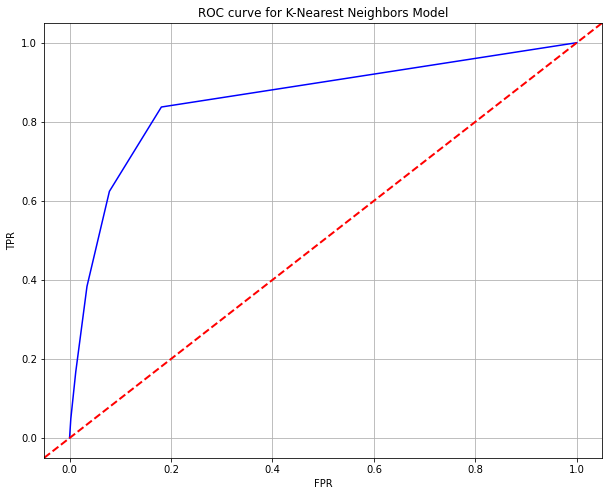

In [368]:
fpr,tpr,th=roc_curve(y_test,ypred_probability_knn)
plt.figure(figsize=(10,8))
plt.plot(fpr,tpr,color='blue')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.title('ROC curve for K-Nearest Neighbors Model')
plt.plot([-0.05,1.05],[-0.05,1.05],'r--',linewidth=2)
plt.show()

#### 2.a).6. ROC AUC Score:

In [135]:
print('The ROC AUC score of the K-Nearest Neighbors Model ')
print('--------------------------------------------------','\n')
print('ROC AUC : ',roc_auc_score(y_test,ypred_probability_knn))

The ROC AUC score of the K-Nearest Neighbors Model 
-------------------------------------------------- 

ROC AUC :  0.8567087480541534


#### 2.a).7. Cross Entropy:

In [136]:
cross_entropy=log_loss(y_test,ypred_knn_test)
print('The Cross Entropy score of K-Nearest Neighbors Model ')
print('----------------------------------------------------','\n')
print('Cross Entropy : ',cross_entropy)

The Cross Entropy score of K-Nearest Neighbors Model 
---------------------------------------------------- 

Cross Entropy :  3.450547908711638


#### 2.a).8. Bias Error and Variance Error:

In [137]:
k=KFold(n_splits=10,shuffle=True, random_state=10)
scores=cross_val_score(estimator=knn_model,X=X_train,y=y_train,cv=k,scoring='accuracy')
print("Mean Score : ",np.mean(scores))
print("Bias error : ",(1-np.mean(scores))*100)
print("Variance error : ",(np.std(scores)/np.mean(scores))*100,'\n')

Mean Score :  0.900485584218513
Bias error :  9.951441578148701
Variance error :  0.440839122845706 



## 2.b) Inferences for K-Nearest Neighbors Classification Model:

* Cross Entropy for K-Nearest Neighbors Model is 3.35


* ROC AUC Score for the K-Nearest Neighbors Model is 85.86 


* The Model Accuracy for the K-Nearest Neighbors Model is coming out to be around 90%.


* f1 weighted avg for the K-Nearest Neighbors Model is around 89%.


* Specificity : 97%


* Sensitivity : 39%


In [76]:
###################################################################################################

## 3. Decision Tree Classification Model using Scikit-learn:

In [260]:
# Classification Model using sklearn:
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred_test_dt=dt.predict(X_test)
y_pred_train_dt=dt.predict(X_train)
y_test_prob_dt=dt.predict_proba(X_test)[:,1]

## 3.a) Model Performance Evaluation:

#### 3.a).1. Confusion Matrix for Decision Tree classification

In [261]:
# Computing the Confusion matrix:

dt_confusion_mat=confusion_matrix(y_test,y_preded_test_dt)
tn = dt_confusion_mat[0,0]
tp = dt_confusion_mat[1,1]
fp = dt_confusion_mat[0,1]
fn = dt_confusion_mat[1,0]
print('Confusion Matrix for Decision Tree Model : ')
print('------------------------------------------------','\n')
print(dt_confusion_mat)

Confusion Matrix for Decision Tree Model : 
------------------------------------------------ 

[[6801  509]
 [ 472  456]]


#### 3.a).2. Graphical Representation of Confusion Matrix:

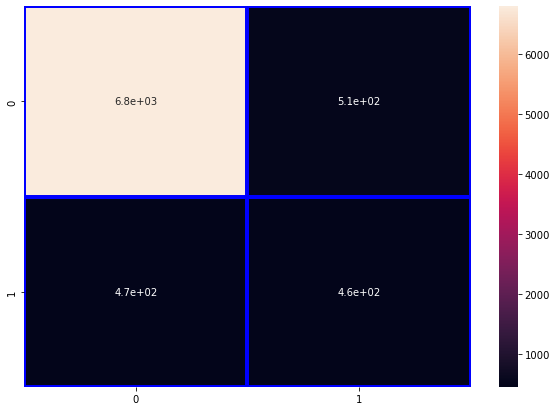

In [262]:
plt.figure(figsize=(10,7))
sns.heatmap(dt_confusion_mat,annot=True,linewidth=3.5,linecolor='blue')
plt.show()

#### Sensitivity and Specificity:

In [263]:
Sensitivity_Decision_tree=(tp/(tp+fn))
print('Sensitivity of the Decision Tree Model: ')
print('---------------------------------------------','\n')
print(Sensitivity_Decision_tree)
print('\n')
Specificity_Decision_tree=(tn/(tn+fp))
print('Specificity of the Decision Tree Model: ')
print('---------------------------------------------','\n')
print(Specificity_Decision_tree)

Sensitivity of the Decision Tree Model: 
--------------------------------------------- 

0.49137931034482757


Specificity of the Decision Tree Model: 
--------------------------------------------- 

0.9303693570451437


#### 3.a).3.  Accuracy Analysis:

In [264]:
print('The Accuracy score of test data for the Decision Tree Model: ')
print(accuracy_score(y_test,y_pred_test_dt),'\n')
print('The Accuracy score of the train data for the Decision Tree Model: ')
print(accuracy_score(y_train,y_pred_train_dt))

The Accuracy score of test data for the Decision Tree Model: 
0.8809176984705025 

The Accuracy score of the train data for the Decision Tree Model: 
1.0


#### 3.a).4.  Decision Tree Model classification report:

In [265]:
# Computing the classification report:

dt_report=classification_report(y_test,y_pred_test_dt)
print('Decision Tree Model classification report: ')
print('-----------------------------------------','\n')
print(dt_report)

Decision Tree Model classification report: 
----------------------------------------- 

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      7310
           1       0.47      0.49      0.48       928

    accuracy                           0.88      8238
   macro avg       0.70      0.71      0.71      8238
weighted avg       0.88      0.88      0.88      8238



#### 3.a).5. ROC Curve for Decision Tree Model:

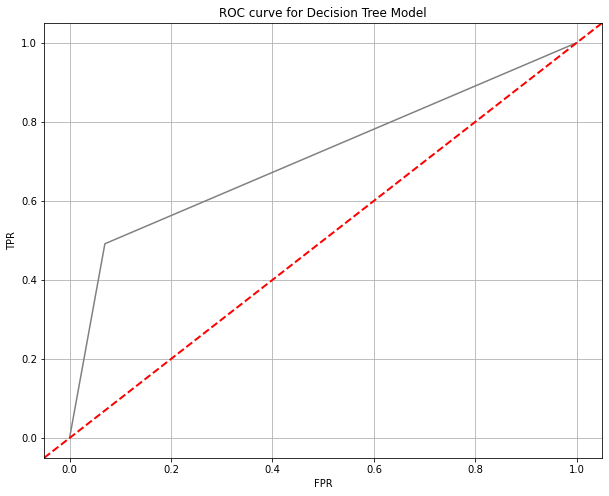

In [367]:
fpr,tpr,th=roc_curve(y_test,y_test_prob_dt)
plt.figure(figsize=(10,8))
plt.plot(fpr,tpr,color='grey')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.title('ROC curve for Decision Tree Model')
plt.plot([-0.05,1.05],[-0.05,1.05],'r--',linewidth=2)
plt.show()

#### 3.a).6. ROC AUC Score:

In [267]:
print('The ROC AUC score of the Decision Tree Model ')
print('--------------------------------------------------','\n')
print('ROC AUC : ',roc_auc_score(y_test,y_test_prob_dt))

The ROC AUC score of the Decision Tree Model 
-------------------------------------------------- 

ROC AUC :  0.7108743336949856


#### 3.a).7. Cross Entropy:

In [268]:
cross_entropy=log_loss(y_test,y_pred_test_dt)
print('The Cross Entropy score of Decision Tree Model ')
print('----------------------------------------------------','\n')
print('Cross Entropy : ',cross_entropy)

The Cross Entropy score of Decision Tree Model 
---------------------------------------------------- 

Cross Entropy :  4.113006389718301


#### 3.a).8. Bias Error and Variance Error:

In [269]:
k=KFold(n_splits=10,shuffle=True, random_state=10)
scores=cross_val_score(estimator=dt,X=X_train,y=y_train,cv=k,scoring='accuracy')
print("Mean Score : ",np.mean(scores))
print("Bias error : ",(1-np.mean(scores))*100)
print("Variance error : ",(np.std(scores)/np.mean(scores))*100,'\n')

Mean Score :  0.8882852807283763
Bias error :  11.171471927162369
Variance error :  0.3854688237452443 



#### 3.a).9. Decision Tree Plot:

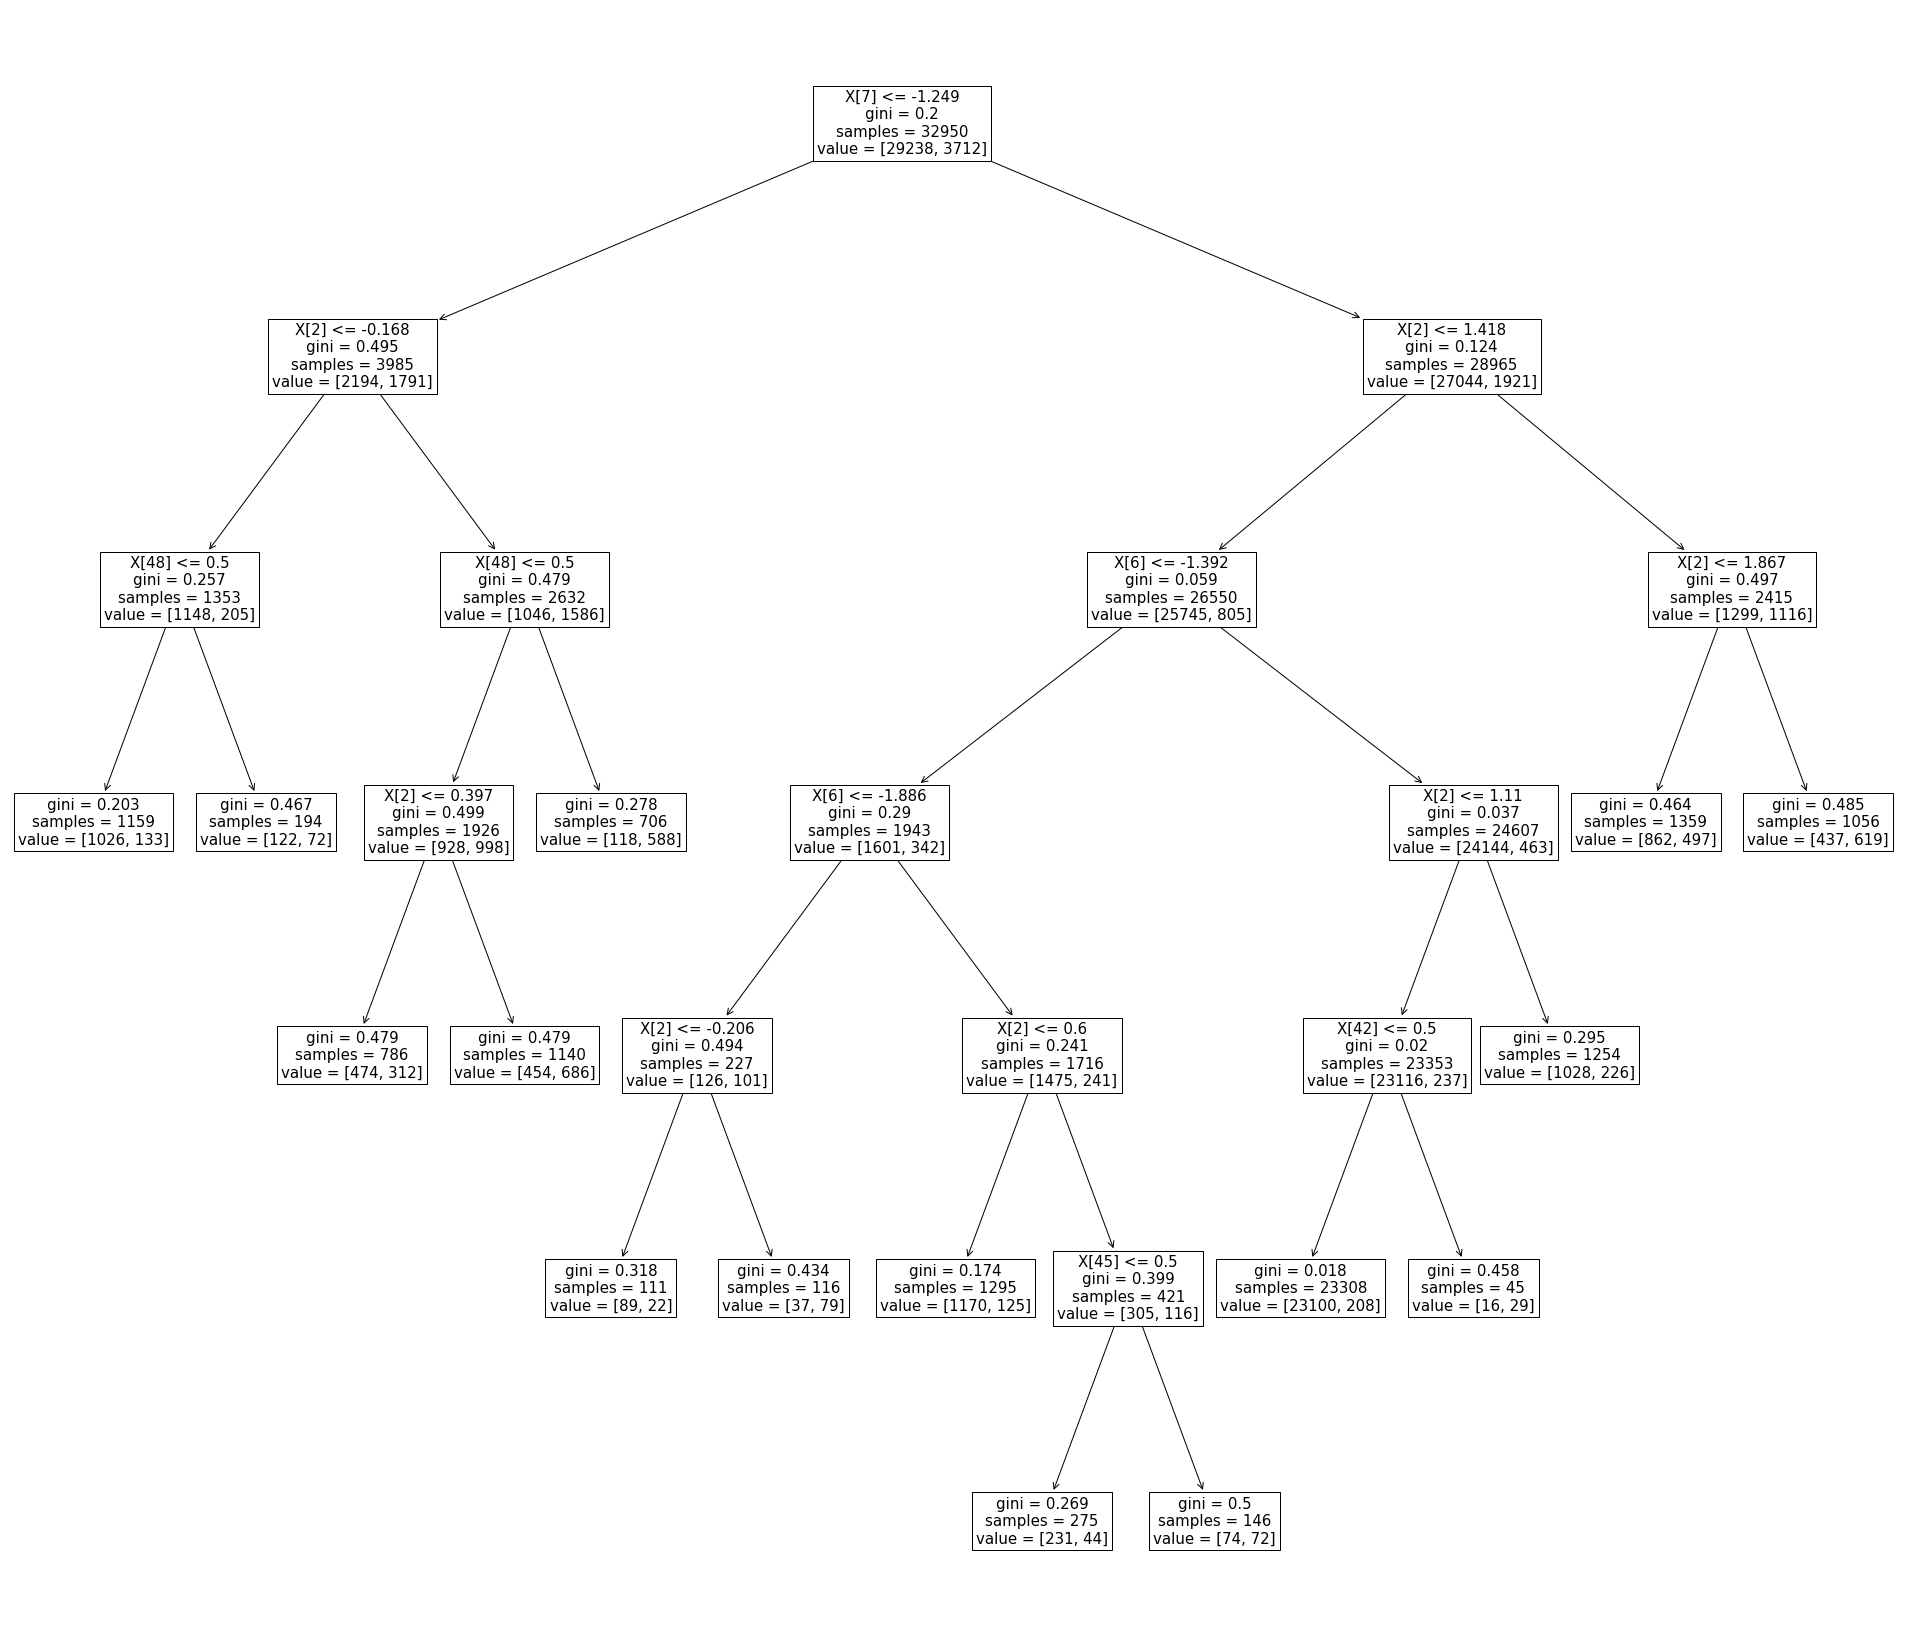

In [270]:
dt=DecisionTreeClassifier(max_leaf_nodes=15)
plt.figure(figsize=(34,30))
plot_tree(dt.fit(X_train,y_train),fontsize=15)
plt.show()

#### 3.a).10. Important features:

In [271]:
features_imp=pd.DataFrame({'Features':X_train.columns,'Score':dt.feature_importances_})
features_imp[features_imp['Score']>0]

,Features,Score
2,duration,0.511946
6,cons.conf.idx,0.046090
7,nr.employed,0.375624
42,month_oct,0.013252
45,day_of_week_thu,0.007733
48,poutcome_success,0.045356


From the Decision Tree Model we have found out The features which contribute significantly for the model. The features are:

    * duration
    * cons.conf.idx
    * nr.employed
    * month_oct
    * day_of_week_thu
    * poutcome_success

## 3.b) Inferences for Decision Tree Classification Model:

* The Cross entropy for the Decision Tree model is 3.82


* ROC AUC Score for the Decision Tree Model is 72.51


* The Model Accuracy for the Decision Tree Model is coming out to be around 89%.


* f1 weighted avg for the Decision Tree Model is around 89%.


* Specificity : 94%


* Sensitivity : 51%

# 4. Naive Bayes Classification Model using Scikit-learn:

In [356]:
# Classification Model using sklearn:
NB=GaussianNB()
NB.fit(X_train,y_train)
y_pred_test_NB=NB.predict(X_test)
y_pred_train_NB=NB.predict(X_train)
y_test_prob_NB=NB.predict_proba(X_test)[:,1]

## 4.a) Model Performance Evaluation:

## 4.a).1. Confusion Matrix for Naive Bayes classification

In [357]:
# Computing the Confusion matrix:

NB_confusion_mat=confusion_matrix(y_test,y_pred_test_dt)
tn = NB_confusion_mat[0,0]
tp = NB_confusion_mat[1,1]
fp = NB_confusion_mat[0,1]
fn = NB_confusion_mat[1,0]
print('Confusion Matrix for Decision Tree Model : ')
print('------------------------------------------------','\n')
print(NB_confusion_mat)

Confusion Matrix for Decision Tree Model : 
------------------------------------------------ 

[[6801  509]
 [ 472  456]]


#### 4.a).2. Graphical Representation of Confusion Matrix:

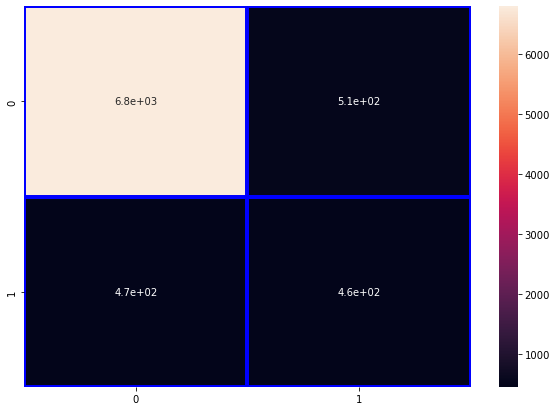

In [358]:
plt.figure(figsize=(10,7))
sns.heatmap(NB_confusion_mat,annot=True,linewidth=3.5,linecolor='blue')
plt.show()

#### 4.a).3. Sensitivity and Specificity:

In [359]:
Sensitivity_NB=(tp/(tp+fn))
print('Sensitivity of the Naive Bayes Model: ')
print('-------------------------------------','\n')
print(Sensitivity_NB)
print('\n')
Specificity_NB=(tn/(tn+fp))
print('Specificity of the naive Bayes Model: ')
print('-------------------------------------','\n')
print(Specificity_NB)

Sensitivity of the Naive Bayes Model: 
------------------------------------- 

0.49137931034482757


Specificity of the naive Bayes Model: 
------------------------------------- 

0.9303693570451437


#### 4.a).4. Accuracy Analysis:

In [360]:
print('The Accuracy score of test data for the Naive Bayes Model: ')
print(accuracy_score(y_test,y_pred_test_NB),'\n')
print('The Accuracy score of the train data for the Naive Bayes Model: ')
print(accuracy_score(y_train,y_pred_train_NB))

The Accuracy score of test data for the Naive Bayes Model: 
0.836489439184268 

The Accuracy score of the train data for the Naive Bayes Model: 
0.8401820940819423


#### 4.a).5. Naive Bayes Model classification report:

In [364]:
# Computing the classification report:

NB_reporttrain=classification_report(y_train,y_pred_train_NB)
print('Naive Bayes Model classification report for train data: ')
print('------------------------------------------------------','\n')
print(NB_reporttrain)
NB_reporttest=classification_report(y_test,y_pred_test_NB)
print('Naive Bayes Model classification report for test data: ')
print('------------------------------------------------------','\n')
print(NB_reporttest)

Naive Bayes Model classification report for train data: 
------------------------------------------------------ 

              precision    recall  f1-score   support

           0       0.94      0.87      0.91     29238
           1       0.37      0.57      0.45      3712

    accuracy                           0.84     32950
   macro avg       0.65      0.72      0.68     32950
weighted avg       0.88      0.84      0.85     32950

Naive Bayes Model classification report for test data: 
------------------------------------------------------ 

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      7310
           1       0.35      0.54      0.43       928

    accuracy                           0.84      8238
   macro avg       0.65      0.71      0.67      8238
weighted avg       0.87      0.84      0.85      8238



#### 4.a).6. ROC Curve for Naive Bayes Model:

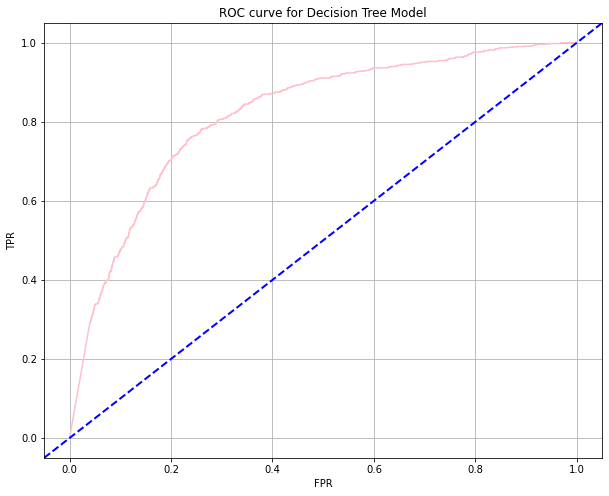

In [372]:
fpr,tpr,th=roc_curve(y_test,y_test_prob_NB)
plt.figure(figsize=(10,8))
plt.plot(fpr,tpr,color='pink')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.title('ROC curve for Decision Tree Model')
plt.plot([-0.05,1.05],[-0.05,1.05],'b--',linewidth=2)
plt.show()

#### 4.a).7. ROC AUC Score:

In [373]:
print('The ROC AUC score of the Decision Tree Model ')
print('--------------------------------------------------','\n')
print('ROC AUC : ',roc_auc_score(y_test,y_test_prob_NB))

The ROC AUC score of the Decision Tree Model 
-------------------------------------------------- 

ROC AUC :  0.8193490111561865


#### 4.a).8. Cross Entropy:

In [374]:
cross_entropyNB=log_loss(y_test,y_pred_test_NB)
print('The Cross Entropy score of Naive Bayes Model ')
print('----------------------------------------------------','\n')
print('Cross Entropy : ',cross_entropyNB)

The Cross Entropy score of Naive Bayes Model 
---------------------------------------------------- 

Cross Entropy :  5.647544092398385


#### 4.a).9. Bias Error and Variance Error:

In [376]:
k=KFold(n_splits=10,shuffle=True, random_state=10)
scores=cross_val_score(estimator=NB,X=X_train,y=y_train,cv=k,scoring='accuracy')
print("Mean Score : ",np.mean(scores))
print("Bias error : ",(1-np.mean(scores))*100)
print("Variance error : ",(np.std(scores)/np.mean(scores))*100,'\n')

Mean Score :  0.8394233687405158
Bias error :  16.05766312594842
Variance error :  0.7219069070443396 



In [98]:
###################################################################################################

                                  Overall Inference:         

# Tabular representation of derived Inferences:

## Model Comparison:

In [407]:
# Initializing the structure of the table:

columns=['Overall Accuracy Score','Accuracy for train data','Accuracy for test data','Specificity',
         'Sensitivity','f1 score weighted avg','ROC AUC Score','Cross Entropy']
indexes=['Logistic Regresion Model','K-Nearest Neighbors Model','Descision Tree Model','Naive Bayes Model']

In [31]:
# Creating a Dataframe for compariosn of Models:
model_data=pd.DataFrame(columns=columns,index=indexes)

# Inserting observed readings to the data fields:
model_data['Overall Accuracy Score']=['91%','90%','89%']
model_data['Accuracy for train data']=['91.24%','93.01%','100%']
model_data['Accuracy for test data']=['90.82%','90.28%','88.94%']
model_data['Specificity']=['97%','97%','94%']
model_data['Sensitivity']=['42%','39%','51%']
model_data['f1 score weighted avg']=['90%','89%','89%']
model_data['ROC AUC Score']=[93.28,85.86,72.51]
model_data['Bias Error']=[]
model-data['Variance Error']=[]
model_data['Cross Entropy']=[3.17,3.35,3.82]
model_data

,Overall Accuracy Score,Accuracy for train data,Accuracy for test data,Specificity,Sensitivity,f1 score weighted avg,ROC AUC Score,Cross Entropy
Logistic Regresion Model,91%,91.24%,90.82%,97%,42%,90%,93.28,3.17
K-Nearest Neighbors Model,90%,93.01%,90.28%,97%,39%,89%,85.86,3.35
Descision Tree Model,89%,100%,88.94%,94%,51%,89%,72.51,3.82


# Inferences based on comparison of Base Models:


#### 1. Overall Accuracy Score: 

    1. Logistic Regression Model has the highest overall accuracy of about 91%.

    2. Decision Tree Model yeilds the lowest overall model accuracy of about 89%.

#### 2. Overfitting/Underfitting:

    1. All the classification models exhibit overfitting of the trained data with respect to the test data.

    2. The model accuracy for train data and test data for both Logistic Regression Model and K-Nearest Neighbors Model has very less overfitting.
    
    3. As observed,the model accuracy for train data and test data for the Decision Tree Model has a considerably high difference in accuracies which can be considered a high overfitting condition in comparison to other models.

#### 3. f1 score weighted avg:

    1. The Logistic Regression Model has the highest weighted harmonic mean between precison and recall of about 90% based on the classification report.
    
    2. Both K-Nearest Neighbors Model and Descision Tree Model have nearly similar weighted harmonic mean between precison and recall of about 89%.
    
    3. We can further look at the recall values of the positive class and negative class to get more insights on the specificity and sensitivity.

#### Sensitivity and Specificity:

    1. Logistic Regression Model :
      * Specificity = 97%
      * Sensitivity = 42% 
    
    2. K-Nearest Neigbors Model :
      * Specificity = 97%
      * Sensitivity = 39% 
    
    3. Decision Tree Model :
      * Specificity = 94%
      * Sensitivity = 51% 

#### 5. ROC AUC Score:

    1. The Logistic Regression Model has the maximum area under the ROC curve with a ROC AUC Score of 93.28.
    
    2. The Decision Tree Model has the minimum area under the ROC curve with a ROC AUC Score of 72.51.

#### 6. Cross Entropy:

    1. Minimum Cross Entropy score for Logistic Regression model : 
    H_logistic(y) = 3.17
    
    2. Maximum Cross Entropy score for Naive Bayes Model : 
    H_Decisiontree(y) = 5.65

                                    MODEL OPTIMIZATION                                  

## 5. Random Forest Classification Model using Scikit-learn:

In [272]:
# Classification Model using sklearn:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred_test_rf=rf.predict(X_test)
y_pred_train_rf=rf.predict(X_train)
y_test_prob_rf=rf.predict_proba(X_test)[:,1]

## 5.a) Model Performance Evaluation:

#### 5.a).1. Confusion Matrix for Random Forest classification

In [273]:
# Computing the Confusion matrix:

rf_confusion_mat=confusion_matrix(y_test,y_pred_test_rf)
tn = rf_confusion_mat[0,0]
tp = rf_confusion_mat[1,1]
fp = rf_confusion_mat[0,1]
fn = rf_confusion_mat[1,0]
print('Confusion Matrix for Random Forest Model : ')
print('------------------------------------------------','\n')
print(rf_confusion_mat)

Confusion Matrix for Random Forest Model : 
------------------------------------------------ 

[[7054  256]
 [ 510  418]]


#### 5.a).2. Graphical Representation of Confusion Matrix:

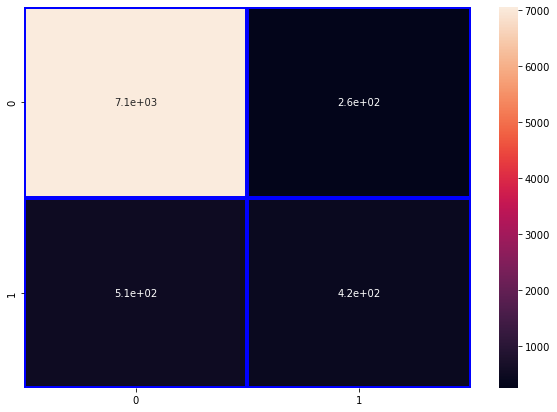

In [274]:
plt.figure(figsize=(10,7))
sns.heatmap(rf_confusion_mat,annot=True,linewidth=3.5,linecolor='blue')
plt.show()

#### 5.a).3. Sensitivity and Specificity:

In [275]:
Sensitivity_random_forest=(tp/(tp+fn))
print('Sensitivity of the Decision Tree Model: ')
print('---------------------------------------------','\n')
print(Sensitivity_random_forest)
print('\n')
Specificity_random_forest=(tn/(tn+fp))
print('Specificity of the Decision Tree Model: ')
print('---------------------------------------------','\n')
print(Specificity_random_forest)

Sensitivity of the Decision Tree Model: 
--------------------------------------------- 

0.4504310344827586


Specificity of the Decision Tree Model: 
--------------------------------------------- 

0.9649794801641587


#### 5.a).4. Accuracy Analysis:

In [276]:
print('The Accuracy score of test data for the Random Forest Model: ')
print(accuracy_score(y_test,y_pred_test_rf),'\n')
print('The Accuracy score of the train data for the Random Forest Model: ')
print(accuracy_score(y_train,y_pred_train_rf))

The Accuracy score of test data for the Random Forest Model: 
0.907016266084001 

The Accuracy score of the train data for the Random Forest Model: 
1.0


#### 4.a).5. Random Forest Model classification report:

In [408]:
# Computing the classification report:

rf_reporttrain=classification_report(y_train,y_pred_train_rf)
print('Random Forest Model classification report for train data: ')
print('---------------------------------------------------------','\n')
print(rf_reporttrain)
rf_report=classification_report(y_test,y_pred_test_rf)
print('Decision Tree Model classification report for test data: ')
print('--------------------------------------------------------','\n')
print(rf_report)

Random Forest Model classification report for train data: 
--------------------------------------------------------- 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29238
           1       1.00      1.00      1.00      3712

    accuracy                           1.00     32950
   macro avg       1.00      1.00      1.00     32950
weighted avg       1.00      1.00      1.00     32950

Decision Tree Model classification report for test data: 
-------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7310
           1       0.62      0.45      0.52       928

    accuracy                           0.91      8238
   macro avg       0.78      0.71      0.74      8238
weighted avg       0.90      0.91      0.90      8238



#### 4.a).6. ROC Curve for Random Forest Model:

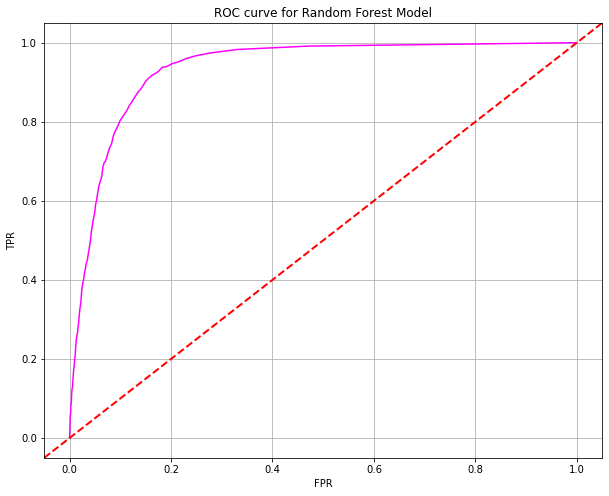

In [378]:
fpr,tpr,th=roc_curve(y_test,y_test_prob_rf)
plt.figure(figsize=(10,8))
plt.plot(fpr,tpr,color='magenta')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.title('ROC curve for Random Forest Model')
plt.plot([-0.05,1.05],[-0.05,1.05],'r--',linewidth=2)
plt.show()

#### 4.a).7. ROC AUC Score:

In [379]:
print('The ROC AUC score of the Random Forest Model ')
print('--------------------------------------------------','\n')
print('ROC AUC : ',roc_auc_score(y_test,y_test_prob_rf))

The ROC AUC score of the Random Forest Model 
-------------------------------------------------- 

ROC AUC :  0.9338140212981744


#### 4.a).8. Cross Entropy:

In [280]:
cross_entropy=log_loss(y_test,y_pred_test_rf)
print('The Cross Entropy score of Decision Tree Model ')
print('----------------------------------------------------','\n')
print('Cross Entropy : ',cross_entropy)

The Cross Entropy score of Decision Tree Model 
---------------------------------------------------- 

Cross Entropy :  3.2115692419815143


#### 4.a).9. Bias Error and Variance Error:

In [281]:
k=KFold(n_splits=10,shuffle=True, random_state=10)
scores=cross_val_score(estimator=rf,X=X_train,y=y_train,cv=k,scoring='accuracy')
print("Mean Score : ",np.mean(scores))
print("Bias error : ",(1-np.mean(scores))*100)
print("Variance error : ",(np.std(scores)/np.mean(scores))*100,'\n')

Mean Score :  0.9126858877086494
Bias error :  8.731411229135055
Variance error :  0.280603923117611 



Optimization

## Hyperparameter Tunning Base models to find out best parameters for further optimization:

Each base model has been chosen and a set of parameters has been considered for fine tuning.
Using these set of parameters we have used ``Grid Search Cross Validation`` technique for Hyperparameter tunning the models where the Cross Validation considered is 10-Fold Cross Validation. 

#### Tuning the Logistic Regression Model:

In [344]:
tune_params=[{'penalty':['l1','l2','elasticnet'],'max_iter':[100, 110, 120, 150, 180, 200],
             }]
k=KFold(n_splits=10,shuffle=True, random_state=10)
grid_dt=GridSearchCV(estimator=LogisticRegression(),
                     param_grid=tune_params,cv=k,scoring='f1_weighted')
grid_model=grid_dt.fit(X_train,y_train)
grid_model.best_params_

{'max_iter': 110, 'penalty': 'l2'}

#### Tuning the Decision Tree Model:

In [384]:
tune_params=[{'criterion':['entropy', 'gini'],'splitter':['best','random'],
 'max_depth': np.arange(0, 200, 10),
 'min_samples_split':[2, 5, 8, 10, 20]}]
k=KFold(n_splits=10,shuffle=True, random_state=10)
grid_dt=GridSearchCV(estimator=DecisionTreeClassifier(),
                     param_grid=tune_params,cv=k,scoring='f1_weighted')
grid_model=grid_dt.fit(X_train,y_train)
grid_model.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_split': 20,
 'splitter': 'best'}

#### Tuning the KNNeighbours Classification Model:

In [396]:
tune_params=[{'n_neighbors':[5,6,7,8],'weights':['uniform','distance'],
 'algorithm':['auto'],
 'leaf_size':np.arange(30, 50, 10)}]
k=KFold(n_splits=10,shuffle=True, random_state=10)
grid_dt=GridSearchCV(estimator=KNeighborsClassifier(),
                     param_grid=tune_params,cv=k,scoring='f1_weighted')
grid_model=grid_dt.fit(X_train,y_train)
grid_model.best_params_

{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 8, 'weights': 'distance'}

#### Tunning the Random Forest Model:

In [414]:
tune_params=[{'criterion':['entropy', 'gini'],
    'n_estimators': [100,200,400,800,1200],'random_state':[10],
 'max_depth': np.arange(0, 100, 10),'min_samples_leaf': [1, 2, 4, 6],
 'min_samples_split':[2, 5, 10, 20]}]
k=KFold(n_splits=10,shuffle=True, random_state=10)
grid_dt=GridSearchCV(estimator=RandomForestClassifier(),
                     param_grid=tune_params,cv=k,scoring='f1_weighted')
grid_model=grid_dt.fit(X_train,y_train)
grid_model.best_params_

KeyboardInterrupt: 

# Refitting the Tunned Based models to compare the performances: 

Overall accuracy of LogisticRegression(max_iter=110) for resampled train data :  91.0
Overall accuracy of LogisticRegression(max_iter=110) for resampled test data :  91.0 

Confusion Matrix for LogisticRegression(max_iter=110) Model : 
[[7089  221]
 [ 545  383]] 

Sensitivity :  41.27
Specificity :  96.98 

Classification report of LogisticRegression(max_iter=110) for resampled train data : 
------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     29238
           1       0.67      0.45      0.54      3712

    accuracy                           0.91     32950
   macro avg       0.80      0.71      0.75     32950
weighted avg       0.90      0.91      0.91     32950
 

Classification report of LogisticRegression(max_iter=110) for resampled test data : 
------------------------------------------------------------------------------- 

              precision    

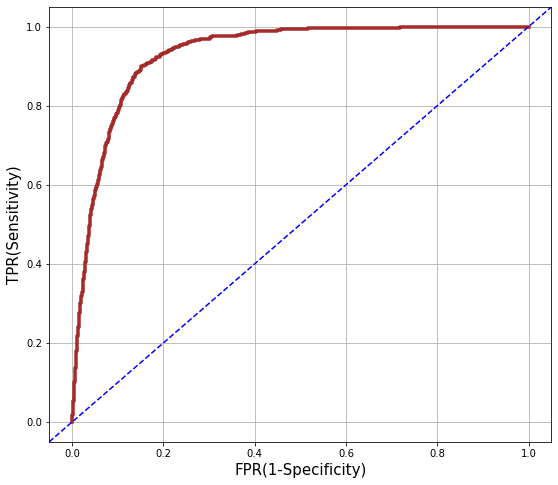

AUC Score of LogisticRegression(max_iter=110) for resampled test data : 
0.931534506344639 

The Cross Entropy score of LogisticRegression(max_iter=110) Model :  3.21156584480865 

Mean Score :  0.9121092564491654
Bias error :  8.789074355083459
Variance error :  0.359353164304254 

---------------------------------------------------------------------------------------------------------------------------- 

Overall accuracy of DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20) for resampled train data :  93.0
Overall accuracy of DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20) for resampled test data :  90.0 

Confusion Matrix for DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20) Model : 
[[7014  296]
 [ 498  430]] 

Sensitivity :  46.34
Specificity :  95.95 

Classification report of DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20) for resampled train data : 
------

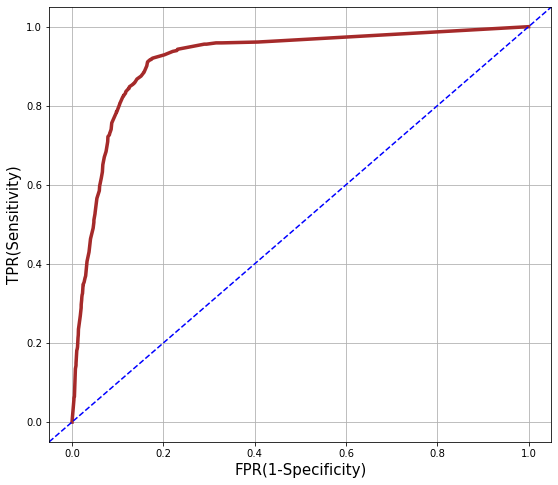

AUC Score of DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20) for resampled test data : 
0.9159395048115477 

The Cross Entropy score of DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20) Model :  3.3289663921338217 

Mean Score :  0.911380880121396
Bias error :  8.861911987860404
Variance error :  0.2634704021958375 

---------------------------------------------------------------------------------------------------------------------------- 

Overall accuracy of KNeighborsClassifier(n_neighbors=8, weights='distance') for resampled train data :  100.0
Overall accuracy of KNeighborsClassifier(n_neighbors=8, weights='distance') for resampled test data :  90.0 

Confusion Matrix for KNeighborsClassifier(n_neighbors=8, weights='distance') Model : 
[[7074  236]
 [ 581  347]] 

Sensitivity :  37.39
Specificity :  96.77 

Classification report of KNeighborsClassifier(n_neighbors=8, weights='distance') for resampled train data : 
----

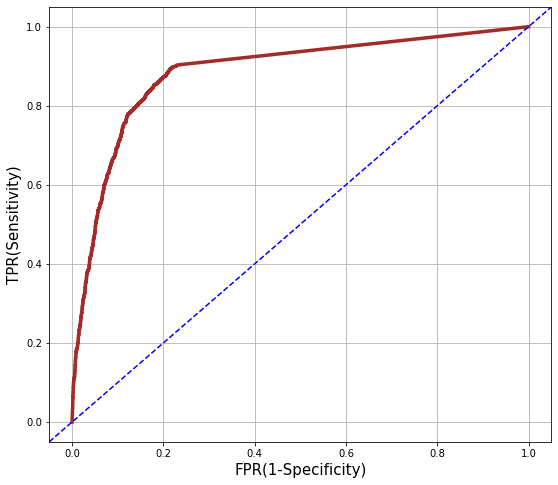

AUC Score of KNeighborsClassifier(n_neighbors=8, weights='distance') for resampled test data : 
0.8849600806641825 

The Cross Entropy score of KNeighborsClassifier(n_neighbors=8, weights='distance') Model :  3.425390752565618 

Mean Score :  0.9035508345978756
Bias error :  9.644916540212446
Variance error :  0.5015398751828585 

---------------------------------------------------------------------------------------------------------------------------- 

Overall accuracy of GaussianNB() for resampled train data :  84.0
Overall accuracy of GaussianNB() for resampled test data :  84.0 

Confusion Matrix for GaussianNB() Model : 
[[6389  921]
 [ 426  502]] 

Sensitivity :  54.09
Specificity :  87.4 

Classification report of GaussianNB() for resampled train data : 
------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.94      0.87      0.91     29238
           1       0.37      0.57  

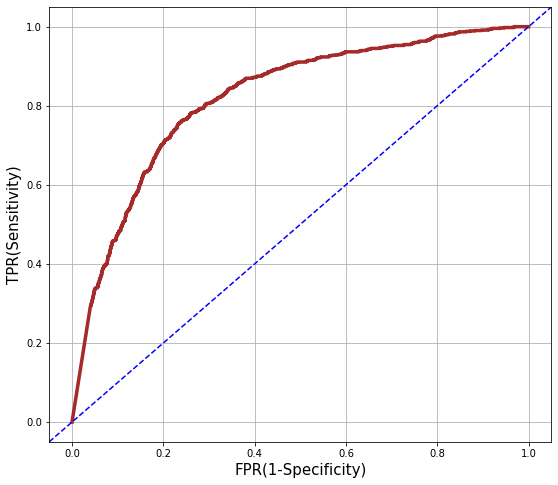

AUC Score of GaussianNB() for resampled test data : 
0.8193490111561865 

The Cross Entropy score of GaussianNB() Model :  5.647544092398385 

Mean Score :  0.8394233687405158
Bias error :  16.05766312594842
Variance error :  0.7219069070443396 

---------------------------------------------------------------------------------------------------------------------------- 

Overall accuracy of RandomForestClassifier() for resampled train data :  100.0
Overall accuracy of RandomForestClassifier() for resampled test data :  91.0 

Confusion Matrix for RandomForestClassifier() Model : 
[[7066  244]
 [ 521  407]] 

Sensitivity :  43.86
Specificity :  96.66 

Classification report of RandomForestClassifier() for resampled train data : 
------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29238
           1       1.00      1.00      1.00      3712

    accuracy    

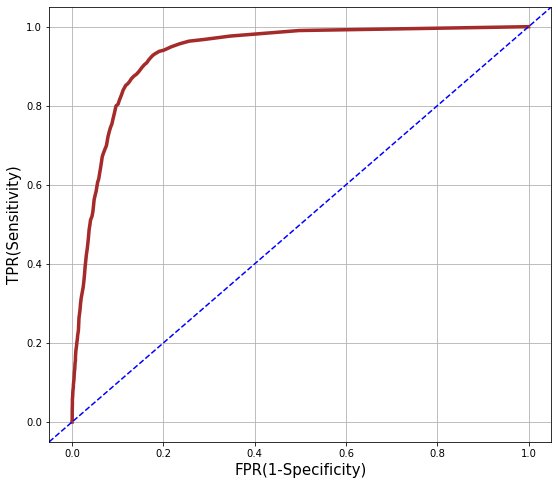

AUC Score of RandomForestClassifier() for resampled test data : 
0.9306856308080571 

The Cross Entropy score of RandomForestClassifier() Model :  3.2073754605340667 

Mean Score :  0.9129893778452199
Bias error :  8.701062215478006
Variance error :  0.23601369544260956 

---------------------------------------------------------------------------------------------------------------------------- 



In [397]:
def tunned_basemodels(model):
    for j in model:
        plt.figure(figsize=(9,8))
        Tuned_base_model=j.fit(X_train,y_train)
        ypred_train=Tuned_base_model.predict(X_train)
        ypred_test=Tuned_base_model.predict(X_test)
        ypred_test_prob=Tuned_base_model.predict_proba(X_test)
        print(f'Overall accuracy of {j} for resampled train data : ',
        np.round(accuracy_score(y_train,ypred_train),2)*100)
        print(f'Overall accuracy of {j} for resampled test data : ',
        np.round(accuracy_score(y_test,ypred_test),2)*100,'\n')
        confusion_mat=confusion_matrix(y_test,ypred_test)
        tn = confusion_mat[0,0]
        tp = confusion_mat[1,1]
        fp = confusion_mat[0,1]
        fn = confusion_mat[1,0]
        print(f'Confusion Matrix for {j} Model : ')
        print(confusion_mat,'\n')
        Sensitivity=((tp/(tp+fn))*100)
        print('Sensitivity : ',np.round(Sensitivity,2))
        Specificity=((tn/(tn+fp))*100)
        print('Specificity : ',np.round(Specificity,2),'\n')
        print(f'Classification report of {j} for resampled train data : ')
        print('-------------------------------------------------------------------------------','\n')
        print(classification_report(y_train,ypred_train),'\n')
        print(f'Classification report of {j} for resampled test data : ')
        print('-------------------------------------------------------------------------------','\n')
        print(classification_report(y_test,ypred_test),'\n')
        fpr,trp,th=roc_curve(y_test,ypred_test_prob[:,1])
        plt.plot(fpr,trp,color='brown',linewidth=3.5)
        plt.xlim([-0.05,1.05])
        plt.ylim([-0.05,1.05])
        plt.grid()
        plt.xlabel('FPR(1-Specificity)',fontsize=15)
        plt.ylabel('TPR(Sensitivity)',fontsize=15)
        plt.plot([-0.05,1.05],[-0.05,1.05],'--b')
        plt.show()
        print(f'AUC Score of {j} for resampled test data : ')
        print(roc_auc_score(y_test,ypred_test_prob[:,1]),'\n')
        cross_entropy=log_loss(y_test,ypred_test)
        print(f'The Cross Entropy score of {j} Model : ',cross_entropy,'\n')
        k=KFold(n_splits=10,shuffle=True, random_state=10)
        scores=cross_val_score(estimator=j,X=X_train,y=y_train,cv=k,scoring='accuracy')
        print("Mean Score : ",np.mean(scores))
        print("Bias error : ",(1-np.mean(scores))*100)
        print("Variance error : ",(np.std(scores)/np.mean(scores))*100,'\n')
        print('----------------------------------------------------------------------------------------------------------------------------','\n')
models=[LogisticRegression(max_iter=110,penalty='l2'),DecisionTreeClassifier(criterion='entropy',
 max_depth=10,min_samples_split=20,splitter='best'),
        KNeighborsClassifier(algorithm='auto',leaf_size=30,n_neighbors=8,weights='distance'),
        GaussianNB(),RandomForestClassifier()]
tunned_basemodels(models)

In [ ]:
Logistic Regression, Decision tree and Random Forest.

### Checking presence of Imbalance in the target variable (y) :

Checking % of subcatgories in the Target variable(y):  

% of Positive class(1) : 
11.265417111780131 

% of Negative class(0) : 
88.73458288821988


<AxesSubplot:xlabel='y', ylabel='count'>

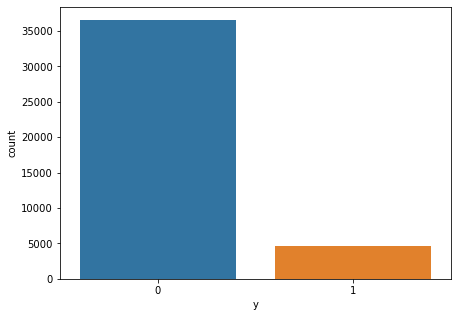

In [20]:
print('Checking % of subcatgories in the Target variable(y): ','\n')
print('% of Positive class(1) : ',)
print((bank_df['y'].value_counts()[1]/bank_df['y'].shape[0])*100,'\n')
print('% of Negative class(0) : ',)
print((bank_df['y'].value_counts()[0]/bank_df['y'].shape[0])*100)
plt.figure(figsize=(7,5))
sns.countplot(bank_df['y'])

Thus we can see that their is imbalance present in the target variable (y).

* 88.73% of 0 class which is the majority class.
* 11.26% of 1 class which is the minority class.

Presence of class imbalance in the target feature can be a defect which might result in faulty predictions by the classification algorithm with a tendency to classify the testing data more towards the majority class.


Thus, in order to remove Imablance we will use SMOTE analysis or the Synthetic Minority OverSampling Technique by which new examples can be synthesized from the existing examples. This type of data augmentation for the minority class can reduce the huge difference between the % distribution of each unique sub-category in the target variable.

### SMOTE Analysis:

Resampled X : (71268, 48)
Resampled y : (71268, 1) 

Checking % of subcatgories in the Target variable(y) after SMOTE analysis:  

% of Positive class(1) :  48.72
% of Negative class(0) :  51.28 

XRes_train : (57014, 48)
yRes_train : (57014, 1)
XRes_test : (14254, 48)
yRes_test : (14254, 1)


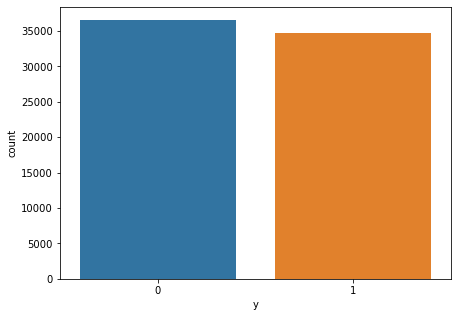

In [21]:
# Performing SMOTE to reduce imbalance:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 
smote=SMOTE(sampling_strategy=0.95,random_state=10)
X_res, y_res = smote.fit_resample(X,y)
print('Resampled X :',X_res.shape)
print('Resampled y :',y_res.shape,'\n')
# Checking the resampled data:
print('Checking % of subcatgories in the Target variable(y) after SMOTE analysis: ','\n')
print('% of Positive class(1) : ',np.round(((y_res['y'].value_counts()[1]/y_res['y'].shape[0])*100),2))
print('% of Negative class(0) : ',np.round((y_res['y'].value_counts()[0]/y_res['y'].shape[0])*100,2),'\n')
plt.figure(figsize=(7,5))
sns.countplot(y_res['y'])

# Splitting the dataset into train and test in the ratio 80:20
rs=10
XRes_train,XRes_test,yRes_train,yRes_test=train_test_split(X_res,y_res,test_size=0.2,random_state=rs)
print('XRes_train :',XRes_train.shape)
print('yRes_train :',yRes_train.shape)
print('XRes_test :',XRes_test.shape)
print('yRes_test :',yRes_test.shape)

# Refitting Logistic Regression, Decision tree, Random Forest algorithm on Resampled data:

In [164]:
# Classification Model using sklearn on resampled datset:

In [426]:
def Res_tunned_classifier(model):
    for j in model:
        res_base_models=j.fit(XRes_train,yRes_train)
        yRes_pred_test_rf=res_base_models.predict(XRes_test)
        yRes_pred_train_rf=res_base_models.predict(XRes_train)
        yRes_test_prob_rf=res_base_models.predict_proba(XRes_test)[:,1]
        print(f'The Accuracy score of resampled test data for the {j} Model: ')
        print(accuracy_score(yRes_test,yRes_pred_test_rf))
        print(f'The Accuracy score of resampled train data for the {j} Model: ')
        print(accuracy_score(yRes_train,yRes_pred_train_rf),'\n')
        rfRes_confusion_mat=confusion_matrix(yRes_test,yRes_pred_test_rf)
        tn = rfRes_confusion_mat[0,0]
        tp = rfRes_confusion_mat[1,1]
        fp = rfRes_confusion_mat[0,1]
        fn = rfRes_confusion_mat[1,0]
        print(f'Confusion Matrix of {j} Model for resampled test data : ')
        print('-----------------------------------------------------------------','\n')
        print(rfRes_confusion_mat,'\n')
        rfRes_reporttrain=classification_report(yRes_train,yRes_pred_train_rf)
        print(f'{j} Model classification report after resampling for train data: ')
        print('------------------------------------------------------------------------','\n')
        print(rfRes_reporttrain,'\n')
        rfRes_reporttest=classification_report(yRes_test,yRes_pred_test_rf)
        print(f'{j} Model classification report after resampling for test data: ')
        print('------------------------------------------------------------------------','\n')
        print(rfRes_reporttest,'\n')
        Sensitivity=(tp/(tp+fn))
        print('Sensitivity : ',Sensitivity)
        Specificity=(tn/(tn+fp))
        print('Specificity : ',Specificity,'\n')
        print(f'AUC score of the {j} Model for resampled test data : ',
              roc_auc_score(yRes_test,yRes_test_prob_rf),'\n')
        cross_entropy=log_loss(yRes_test,yRes_pred_test_rf)
        print(f'The Cross Entropy score of {j} Model : ',cross_entropy,'\n')
        k=KFold(n_splits=10,shuffle=True, random_state=10)
        scores=cross_val_score(estimator=rf_clf,X=XRes_train,y=yRes_train,cv=k,scoring='accuracy')
        print("Mean Score : ",np.mean(scores))
        print("Bias error : ",(1-np.mean(scores))*100)
        print("Variance error : ",(np.std(scores)/np.mean(scores))*100,'\n')
        print('------------------------------------------------------------------------------------------------------------------------------------------------------------','\n')
model=[LogisticRegression(max_iter=110,penalty='l2'),
        DecisionTreeClassifier(criterion='entropy',
 max_depth=10,min_samples_split=20,splitter='best'),RandomForestClassifier()]
Random_forest_classifier(model)

The Accuracy score of resampled test data for the LogisticRegression(max_iter=110) Model: 
0.9051494317384594
The Accuracy score of resampled train data for the LogisticRegression(max_iter=110) Model: 
0.9049531693969902 

Confusion Matrix of LogisticRegression(max_iter=110) Model for resampled test data : 
----------------------------------------------------------------- 

[[6566  745]
 [ 607 6336]] 

LogisticRegression(max_iter=110) Model classification report after resampling for test data: 
------------------------------------------------------------------------ 

              precision    recall  f1-score   support

           0       0.92      0.89      0.91     29237
           1       0.89      0.92      0.90     27777

    accuracy                           0.90     57014
   macro avg       0.90      0.91      0.90     57014
weighted avg       0.91      0.90      0.90     57014
 

LogisticRegression(max_iter=110) Model classification report after resampling for test data: 
--

Observations:

* Overall accuracy of RandomForestClassifier() for resampled train data : 100%
* Overall accuracy of RandomForestClassifier() for resampled test data : 94.6% 
* Sensitivity :  0.97
* Specificity :  0.92
* f1-score weighted average : 95%
* Cross Entropy score of Random Forest Model :  1.85
* Bias Error : 5.612408895
* variance error : 0.1976

#### The Random Forest Model given by the function :  ``Random_forest_classifier(model)`` has better Precision and Recall than the previous model built with actual training data. 

# Feature Extraction:

### Using Recursive Feature Elimination:

In [285]:
rfe=RFE(estimator=RandomForestClassifier(),n_features_to_select=None,step=1,verbose=0)
rfe_model=rfe.fit(XRes_train,yRes_train)
features_imp=pd.DataFrame({'Features':X_res.columns,
                           'Rank':rfe_model.ranking_}).sort_values(by='Rank',ascending=True)
print(features_imp[features_imp['Rank']==1],'\n')
XRes_new=features_imp[features_imp['Rank']==1]
print(list(XRes_new['Features']))

                       Features  Rank
24        education_high.school     1
46              day_of_week_tue     1
45              day_of_week_thu     1
44              day_of_week_mon     1
40                    month_may     1
34            contact_telephone     1
33                     loan_yes     1
31                  housing_yes     1
29              default_unknown     1
27  education_university.degree     1
47              day_of_week_wed     1
23           education_basic.9y     1
20               marital_single     1
19              marital_married     1
16               job_technician     1
48             poutcome_success     1
4                      previous     1
5                cons.price.idx     1
1                           age     1
6                 cons.conf.idx     1
7                   nr.employed     1
2                      duration     1
8               job_blue-collar     1
3                      campaign     1 

['education_high.school', 'day_of_week_tue', 'da

The following variables are obtained after Recurcise feature elimination:


'education_high.school', 'day_of_week_tue', 'day_of_week_thu', 'day_of_week_mon', 'month_may', 'contact_telephone', 'loan_yes', 'housing_yes', 'default_unknown', 'education_university.degree', 'day_of_week_wed', 'education_basic.9y', 'marital_single', 'marital_married', 'job_technician', 'poutcome_success', 'previous', 'cons.price.idx', 'age', 'cons.conf.idx', 'nr.employed', 'duration', 'job_blue-collar', 'campaign'


# Refitting the Logistic Regression model, Decision Tree model Naive Bayes and Random Forest model on the new dataset containing features obtained after recursive elimination:

In [436]:
X.head()

,age,duration,campaign,previous,cons.price.idx,cons.conf.idx,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_success
0,1.427459,0.389913,-1.045497,-0.397706,0.700791,0.911782,0.140827,0,0,1,...,0,1,0,0,0,1,0,0,0,0
1,1.492292,-0.234770,-1.045497,-0.397706,0.700791,0.911782,0.140827,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,-0.158076,0.225113,-1.045497,-0.397706,0.700791,0.911782,0.140827,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0.150155,-0.220434,-1.045497,-0.397706,0.700791,0.911782,0.140827,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,1.427459,0.579397,-1.045497,-0.397706,0.700791,0.911782,0.140827,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [439]:
X.to_csv('BankPrediction_data.csv')

In [435]:
X.shape

(41188, 48)

Overall accuracy of LogisticRegression(max_iter=110) for resampled train data :  89.0
Overall accuracy of LogisticRegression(max_iter=110) for resampled test data :  89.0 

Confusion Matrix for LogisticRegression(max_iter=110) Model : 
[[6420  891]
 [ 648 6295]] 

Sensitivity :  0.9066685870661098
Specificity :  0.8781288469429627 

Classification report of LogisticRegression(max_iter=110) for resampled train data : 
------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.91      0.88      0.89     29237
           1       0.88      0.91      0.89     27777

    accuracy                           0.89     57014
   macro avg       0.89      0.89      0.89     57014
weighted avg       0.89      0.89      0.89     57014
 

Classification report of LogisticRegression(max_iter=110) for resampled test data : 
------------------------------------------------------------------------------- 

 

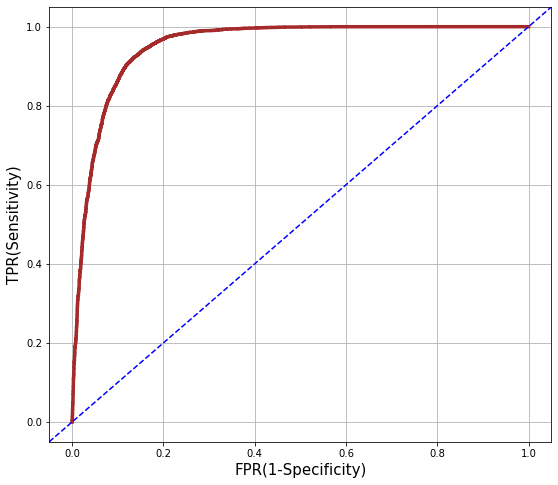

AUC Score of LogisticRegression(max_iter=110) for resampled test data : 
0.9516637942431871 

The Cross Entropy score of LogisticRegression(max_iter=110) Model :  3.7291910560599026 

Mean Score :  0.8924123749942398
Bias error :  10.758762500576024
Variance error :  0.21879522316532932 

---------------------------------------------------------------------------------------------------------------------------- 

Overall accuracy of DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20) for resampled train data :  91.0
Overall accuracy of DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20) for resampled test data :  90.0 

Confusion Matrix for DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20) Model : 
[[6392  919]
 [ 462 6481]] 

Sensitivity :  0.9334581592971338
Specificity :  0.8742990015045822 

Classification report of DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20) fo

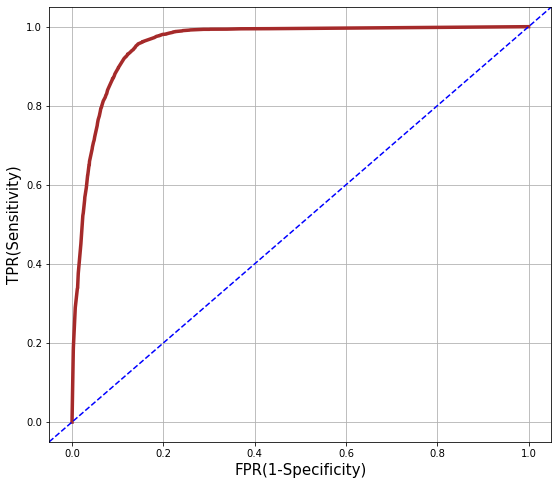

AUC Score of DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20) for resampled test data : 
0.9576590240166754 

The Cross Entropy score of DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20) Model :  3.346343835513541 

Mean Score :  0.8987793775034145
Bias error :  10.122062249658548
Variance error :  0.2928612534890073 

---------------------------------------------------------------------------------------------------------------------------- 

Overall accuracy of RandomForestClassifier() for resampled train data :  100.0
Overall accuracy of RandomForestClassifier() for resampled test data :  94.0 

Confusion Matrix for RandomForestClassifier() Model : 
[[6710  601]
 [ 183 6760]] 

Sensitivity :  0.9736425176436699
Specificity :  0.9177951032690467 

Classification report of RandomForestClassifier() for resampled train data : 
------------------------------------------------------------------------------- 

              preci

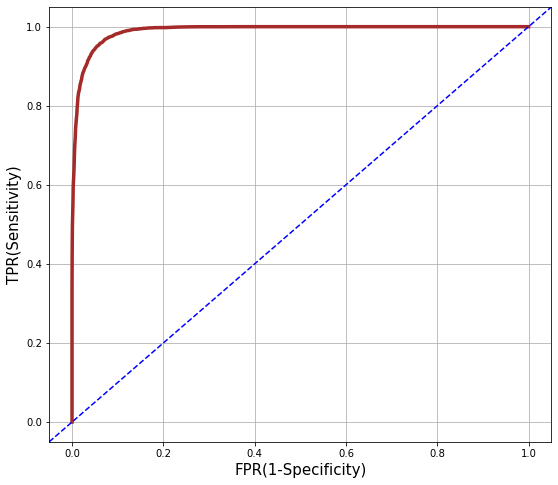

AUC Score of RandomForestClassifier() for resampled test data : 
0.9897222676481665 

The Cross Entropy score of RandomForestClassifier() Model :  1.899739108437318 

Mean Score :  0.9426105563024351
Bias error :  5.738944369756494
Variance error :  0.3222254592214097 

---------------------------------------------------------------------------------------------------------------------------- 



In [406]:
def model_imp_features(model):
    for j in model:
        X_new=X[['education_high.school', 'day_of_week_tue', 'day_of_week_thu', 
                             'day_of_week_mon', 'month_may', 'contact_telephone', 'loan_yes', 
                             'housing_yes', 'default_unknown', 'education_university.degree', 
                             'day_of_week_wed', 'education_basic.9y', 'marital_single', 
                             'marital_married', 'job_technician', 'poutcome_success', 'previous', 
                             'cons.price.idx', 'age', 'cons.conf.idx', 'nr.employed', 
                             'duration', 'job_blue-collar', 'campaign']]
        Y=bank_df['y']
        smt=SMOTE(sampling_strategy=0.95,random_state=10)
        Xnew_res, Y_res = smt.fit_resample(X_new,Y)
        XRes_train,XRes_test,YRes_train,YRes_test=train_test_split(Xnew_res,Y_res,test_size=0.2,random_state=10)
        plt.figure(figsize=(9,8))
        Res_new_model=j.fit(XRes_train,YRes_train)
        YRespred_train=Res_new_model.predict(XRes_train)
        YRespred_test=Res_new_model.predict(XRes_test)
        YRespred_test_prob=Res_new_model.predict_proba(XRes_test)
        print(f'Overall accuracy of {j} for resampled train data : ',
        np.round(accuracy_score(YRes_train,YRespred_train),2)*100)
        print(f'Overall accuracy of {j} for resampled test data : ',
        np.round(accuracy_score(YRes_test,YRespred_test),2)*100,'\n')
        confusion_mat=confusion_matrix(YRes_test,YRespred_test)
        tn = confusion_mat[0,0]
        tp = confusion_mat[1,1]
        fp = confusion_mat[0,1]
        fn = confusion_mat[1,0]
        print(f'Confusion Matrix for {j} Model : ')
        print(confusion_mat,'\n')
        Sensitivity=(tp/(tp+fn))
        print('Sensitivity : ',Sensitivity)
        Specificity=(tn/(tn+fp))
        print('Specificity : ',Specificity,'\n')
        print(f'Classification report of {j} for resampled train data : ')
        print('-------------------------------------------------------------------------------','\n')
        print(classification_report(YRes_train,YRespred_train),'\n')
        print(f'Classification report of {j} for resampled test data : ')
        print('-------------------------------------------------------------------------------','\n')
        print(classification_report(YRes_test,YRespred_test),'\n')
        fpr,trp,th=roc_curve(YRes_test,YRespred_test_prob[:,1])
        plt.plot(fpr,trp,color='brown',linewidth=3.5)
        plt.xlim([-0.05,1.05])
        plt.ylim([-0.05,1.05])
        plt.grid()
        plt.xlabel('FPR(1-Specificity)',fontsize=15)
        plt.ylabel('TPR(Sensitivity)',fontsize=15)
        plt.plot([-0.05,1.05],[-0.05,1.05],'--b')
        plt.show()
        print(f'AUC Score of {j} for resampled test data : ')
        print(roc_auc_score(YRes_test,YRespred_test_prob[:,1]),'\n')
        cross_entropy=log_loss(YRes_test,YRespred_test)
        print(f'The Cross Entropy score of {j} Model : ',cross_entropy,'\n')
        k=KFold(n_splits=10,shuffle=True, random_state=10)
        scores=cross_val_score(estimator=j,X=XRes_train,y=YRes_train,cv=k,scoring='accuracy')
        print("Mean Score : ",np.mean(scores))
        print("Bias error : ",(1-np.mean(scores))*100)
        print("Variance error : ",(np.std(scores)/np.mean(scores))*100,'\n')
        print('----------------------------------------------------------------------------------------------------------------------------','\n')
models=[LogisticRegression(max_iter=110,penalty='l2'),
        DecisionTreeClassifier(criterion='entropy',
 max_depth=10,min_samples_split=20,splitter='best'),RandomForestClassifier()]
model_imp_features(models)

From the above analysis it can be inferred that :
    
    * The Sensitivity and Specificity of both Logistic Regression model and Decision Tree model has increased significantly from the base models resulting in an improved weighted-avgerage of Precision and Recall rates.
    
    * The Decision Tree Model has a better overall performance than the Logistic Model for the new dataset obtained after recursive feature elimination and resampling the data.
    
    * The Random Forest Model has not shown any major improvement from the previous model but has the best overall performance as compared to the Logistic Regression and Decision Tree model.

 ## Conclusion 

Therefore we will be considering the Random Forest Classifier model.

Random Forest Model :
    
    * Overall accuracy of RandomForestClassifier() for resampled train data : 100%
    * Overall accuracy of RandomForestClassifier() for resampled test data : 94% 
    * Sensitivity :  0.97
    * Specificity :  0.92
    * f1-score weighted average : 94%
    * AUC Score of RandomForestClassifier() for resampled test data : 0.9897
    * Bias Error : 5.738944369756494
    * variance error : 0.3222254592214097

# Boosting Algorithms on the selected features:

* AdaBoost Model
* GradientBoost Model
* XGBoost Model

Overall accuracy of AdaBoostClassifier() for resampled train data :  90.0
Overall accuracy of AdaBoostClassifier() for resampled test data :  90.0 

Confusion Matrix for AdaBoostClassifier() Model : 
[[6540  771]
 [ 690 6253]] 

Sensitivity :  0.9006193288203946
Specificity :  0.8945424702503078 

Classification report of AdaBoostClassifier() for resampled train data : 
------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.90      0.89      0.90     29237
           1       0.89      0.90      0.89     27777

    accuracy                           0.90     57014
   macro avg       0.90      0.90      0.90     57014
weighted avg       0.90      0.90      0.90     57014
 

Classification report of AdaBoostClassifier() for resampled test data : 
------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

      

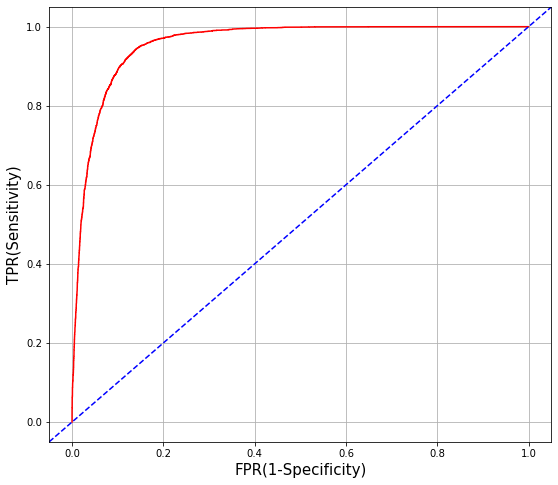

AUC Score for AdaBoostClassifier() for resampled test data : 
0.9578587668352375 

The Cross Entropy score of AdaBoostClassifier() Model :  3.5401830224907536 

Mean Score :  0.8952187525052218
Bias error :  10.478124749477825
Variance error :  0.3794162941775748 

---------------------------------------------------------------------------------------------------------------------------- 

Overall accuracy of GradientBoostingClassifier() for resampled train data :  91.0
Overall accuracy of GradientBoostingClassifier() for resampled test data :  91.0 

Confusion Matrix for GradientBoostingClassifier() Model : 
[[6417  894]
 [ 411 6532]] 

Sensitivity :  0.9408036871669307
Specificity :  0.877718506360279 

Classification report of GradientBoostingClassifier() for resampled train data : 
------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     29237
           1

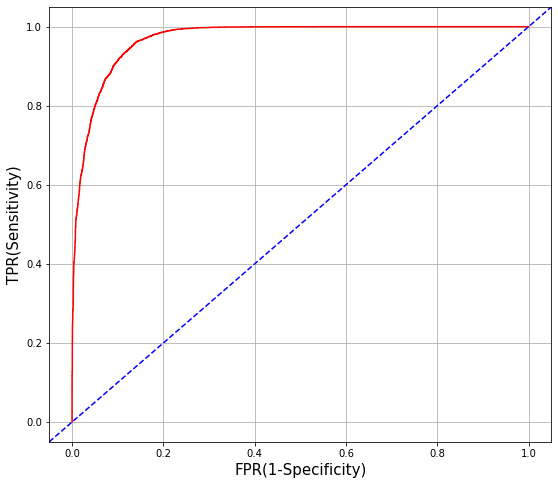

AUC Score for GradientBoostingClassifier() for resampled test data : 
0.9698133912715561 

The Cross Entropy score of GradientBoostingClassifier() Model :  3.1621873183289635 

Mean Score :  0.9058477313665179
Bias error :  9.415226863348213
Variance error :  0.3081681195676774 

---------------------------------------------------------------------------------------------------------------------------- 

Overall accuracy of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
      

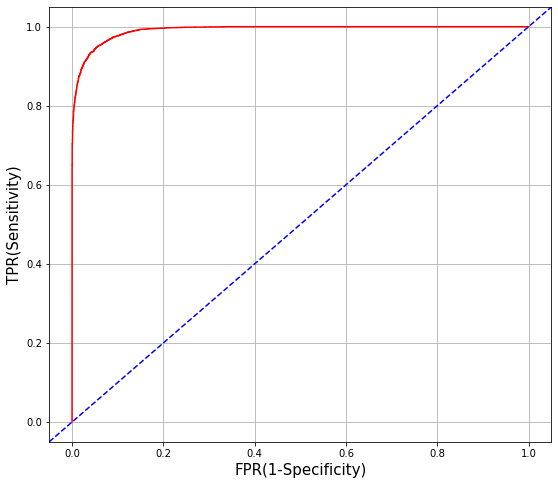

AUC Score for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None) for resampled test data : 
0.9911896848939327 

The Cross Entropy score of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_d

In [22]:
def model_imp_boosting(model):
    for j in model:
        X_new=X[['education_high.school', 'day_of_week_tue', 'day_of_week_thu', 
                             'day_of_week_mon', 'month_may', 'contact_telephone', 'loan_yes', 
                             'housing_yes', 'default_unknown', 'education_university.degree', 
                             'day_of_week_wed', 'education_basic.9y', 'marital_single', 
                             'marital_married', 'job_technician', 'poutcome_success', 'previous', 
                             'cons.price.idx', 'age', 'cons.conf.idx', 'nr.employed', 
                             'duration', 'job_blue-collar', 'campaign']]
        Y=bank_df['y']
        smt=SMOTE(sampling_strategy=0.95,random_state=10)
        Xnew_res, Y_res = smt.fit_resample(X_new,Y)
        XRes_train,XRes_test,YRes_train,YRes_test=train_test_split(Xnew_res,Y_res,test_size=0.2,random_state=10)
        plt.figure(figsize=(9,8))
        Res_model=j.fit(XRes_train,YRes_train)
        YRespred_train=Res_model.predict(XRes_train)
        YRespred_test=Res_model.predict(XRes_test)
        YRespred_test_prob=Res_model.predict_proba(XRes_test)
        print(f'Overall accuracy of {j} for resampled train data : ',
        np.round(accuracy_score(YRes_train,YRespred_train),2)*100)
        print(f'Overall accuracy of {j} for resampled test data : ',
        np.round(accuracy_score(YRes_test,YRespred_test),2)*100,'\n')
        confusion_mat=confusion_matrix(YRes_test,YRespred_test)
        tn = confusion_mat[0,0]
        tp = confusion_mat[1,1]
        fp = confusion_mat[0,1]
        fn = confusion_mat[1,0]
        print(f'Confusion Matrix for {j} Model : ')
        print(confusion_mat,'\n')
        Sensitivity=(tp/(tp+fn))
        print('Sensitivity : ',Sensitivity)
        Specificity=(tn/(tn+fp))
        print('Specificity : ',Specificity,'\n')
        print(f'Classification report of {j} for resampled train data : ')
        print('-------------------------------------------------------------------------------','\n')
        print(classification_report(YRes_train,YRespred_train),'\n')
        print(f'Classification report of {j} for resampled test data : ')
        print('-------------------------------------------------------------------------------','\n')
        print(classification_report(YRes_test,YRespred_test),'\n')
        fpr,trp,th=roc_curve(YRes_test,YRespred_test_prob[:,1])
        plt.plot(fpr,trp,color='red')
        plt.xlim([-0.05,1.05])
        plt.ylim([-0.05,1.05])
        plt.grid()
        plt.xlabel('FPR(1-Specificity)',fontsize=15)
        plt.ylabel('TPR(Sensitivity)',fontsize=15)
        plt.plot([-0.05,1.05],[-0.05,1.05],'--b')
        plt.show()
        print(f'AUC Score for {j} for resampled test data : ')
        print(roc_auc_score(YRes_test,YRespred_test_prob[:,1]),'\n')
        cross_entropy=log_loss(YRes_test,YRespred_test)
        print(f'The Cross Entropy score of {j} Model : ',cross_entropy,'\n')
        k=KFold(n_splits=10,shuffle=True, random_state=10)
        scores=cross_val_score(estimator=j,X=XRes_train,y=YRes_train,cv=k,scoring='accuracy')
        print("Mean Score : ",np.mean(scores))
        print("Bias error : ",(1-np.mean(scores))*100)
        print("Variance error : ",(np.std(scores)/np.mean(scores))*100,'\n')
        print('----------------------------------------------------------------------------------------------------------------------------','\n')
boosting_classifier=[AdaBoostClassifier(),GradientBoostingClassifier(),
                     XGBClassifier(eval_metric='logloss')]
model_imp_boosting(boosting_classifier)

# Boosting Algorithms on complete Resampled data :

* AdaBoost Model
* GradientBoost Model
* XGBoost Model

Overall accuracy of AdaBoostClassifier() for resampled train data :  90.0
Overall accuracy of AdaBoostClassifier() for resampled test data :  90.0 

Confusion Matrix for AdaBoostClassifier() Model : 
[[6577  734]
 [ 653 6290]] 

Sensitivity :  0.9059484372749532
Specificity :  0.8996033374367391 

Classification report of AdaBoostClassifier() for resampled train data : 
------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.91      0.90      0.90     29237
           1       0.89      0.90      0.90     27777

    accuracy                           0.90     57014
   macro avg       0.90      0.90      0.90     57014
weighted avg       0.90      0.90      0.90     57014
 

Classification report of AdaBoostClassifier() for resampled test data : 
------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

      

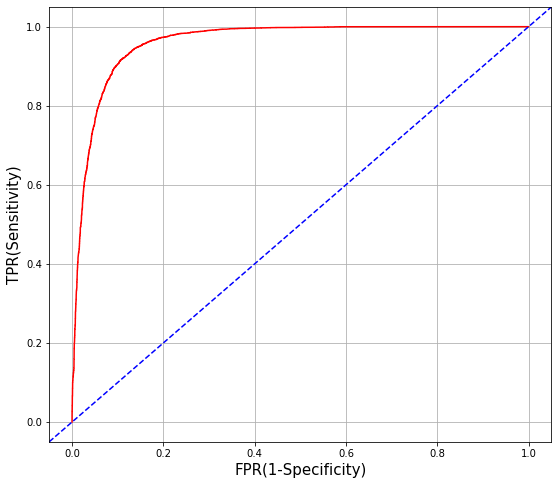

AUC Score for AdaBoostClassifier() for resampled test data : 
0.9605577968424244 

The Cross Entropy score of AdaBoostClassifier() Model :  3.360872019380868 

Mean Score :  0.8991474786032911
Bias error :  10.085252139670885
Variance error :  0.36424727176963523 

---------------------------------------------------------------------------------------------------------------------------- 

Overall accuracy of GradientBoostingClassifier() for resampled train data :  91.0
Overall accuracy of GradientBoostingClassifier() for resampled test data :  91.0 

Confusion Matrix for GradientBoostingClassifier() Model : 
[[6418  893]
 [ 359 6584]] 

Sensitivity :  0.9482932449949589
Specificity :  0.877855286554507 

Classification report of GradientBoostingClassifier() for resampled train data : 
------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     29237
           1

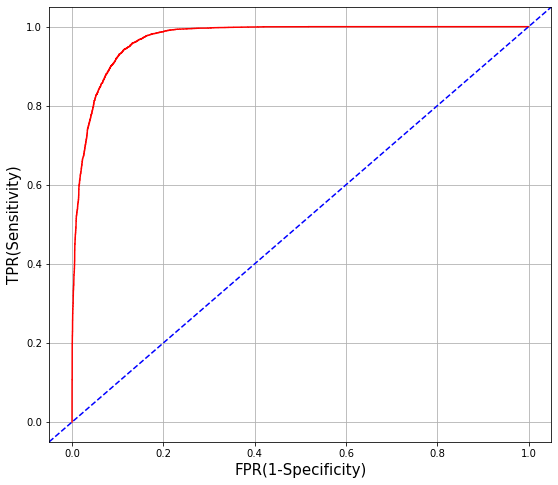

AUC Score for GradientBoostingClassifier() for resampled test data : 
0.9711705746736232 

The Cross Entropy score of GradientBoostingClassifier() Model :  3.0337633006126947 

Mean Score :  0.9101273838559955
Bias error :  8.987261614400454
Variance error :  0.2082533457686795 

---------------------------------------------------------------------------------------------------------------------------- 

Overall accuracy of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
      

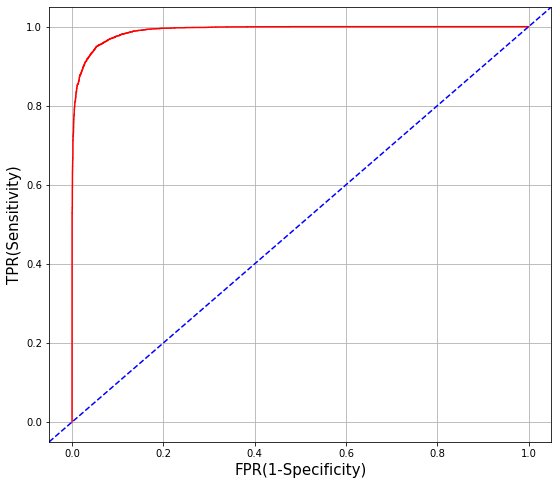

AUC Score for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None) for resampled test data : 
0.9904988690663661 

The Cross Entropy score of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_d

In [403]:
def Res_boosting_algorithm(model):
    for j in model:
        plt.figure(figsize=(9,8))
        Res_xgboost_model=j.fit(XRes_train,yRes_train)
        yRespred_train=Res_xgboost_model.predict(XRes_train)
        yRespred_test=Res_xgboost_model.predict(XRes_test)
        yRespred_test_prob=Res_xgboost_model.predict_proba(XRes_test)
        print(f'Overall accuracy of {j} for resampled train data : ',
        np.round(accuracy_score(yRes_train,yRespred_train),2)*100)
        print(f'Overall accuracy of {j} for resampled test data : ',
        np.round(accuracy_score(yRes_test,yRespred_test),2)*100,'\n')
        confusion_mat=confusion_matrix(yRes_test,yRespred_test)
        tn = confusion_mat[0,0]
        tp = confusion_mat[1,1]
        fp = confusion_mat[0,1]
        fn = confusion_mat[1,0]
        print(f'Confusion Matrix for {j} Model : ')
        print(confusion_mat,'\n')
        Sensitivity=(tp/(tp+fn))
        print('Sensitivity : ',Sensitivity)
        Specificity=(tn/(tn+fp))
        print('Specificity : ',Specificity,'\n')
        print(f'Classification report of {j} for resampled train data : ')
        print('-------------------------------------------------------------------------------','\n')
        print(classification_report(yRes_train,yRespred_train),'\n')
        print(f'Classification report of {j} for resampled test data : ')
        print('-------------------------------------------------------------------------------','\n')
        print(classification_report(yRes_test,yRespred_test),'\n')
        fpr,trp,th=roc_curve(yRes_test,yRespred_test_prob[:,1])
        plt.plot(fpr,trp,color='red')
        plt.xlim([-0.05,1.05])
        plt.ylim([-0.05,1.05])
        plt.grid()
        plt.xlabel('FPR(1-Specificity)',fontsize=15)
        plt.ylabel('TPR(Sensitivity)',fontsize=15)
        plt.plot([-0.05,1.05],[-0.05,1.05],'--b')
        plt.show()
        print(f'AUC Score for {j} for resampled test data : ')
        print(roc_auc_score(yRes_test,yRespred_test_prob[:,1]),'\n')
        cross_entropy=log_loss(yRes_test,yRespred_test)
        print(f'The Cross Entropy score of {j} Model : ',cross_entropy,'\n')
        k=KFold(n_splits=10,shuffle=True, random_state=10)
        scores=cross_val_score(estimator=j,X=XRes_train,y=yRes_train,cv=k,scoring='accuracy')
        print("Mean Score : ",np.mean(scores))
        print("Bias error : ",(1-np.mean(scores))*100)
        print("Variance error : ",(np.std(scores)/np.mean(scores))*100,'\n')
        print('----------------------------------------------------------------------------------------------------------------------------','\n')
boosting_classifier=[AdaBoostClassifier(),GradientBoostingClassifier(),
                     XGBClassifier(eval_metric='logloss')]
Res_boosting_algorithm(boosting_classifier)

# Model Comparison:

Considering the Random Forest Model and the Boosting models on the selected resampled features, we will conclude on which model to choose for the final predictive model for the problem statement.

In [315]:
# Initializing the structure of the table:
indexes=['Random Forest Model','AdaBoost Model','GradientBoost Model',
                     'XGBoost Model']
#  Dataframe for compariosn of Optimization Models:
optModel_data=pd.DataFrame(index=indexes)
# Inserting observed readings to the data fields:
optModel_data['Overall Accuracy']=['95%','90%','91%','95%']
optModel_data['Accuracy for train data']=['100%','90%','91%','97%']
optModel_data['Accuracy for test data']=['95%','90%','91%','95%']
optModel_data['Specificity']=['92.23%','89.45%','87.78%','93.86%']
optModel_data['Sensitivity']=['97.30%','90.06%','94.82%','95.32%']
optModel_data['f1 score weighted avg']=['95%','90%','91%','95%']
optModel_data['ROC AUC Score']=[0.99,0.96,0.97,0.99]
optModel_data['Bias Error']=[5.75,10.48,9.41,5.46]
optModel_data['Variance Error']=[0.29,0.38,0.30,0.26]
optModel_data['Cross Entropy']=[1.88,3.54,3.16,1.88]
optModel_data

,Overall Accuracy,Accuracy for train data,Accuracy for test data,Specificity,Sensitivity,f1 score weighted avg,ROC AUC Score,Bias Error,Variance Error,Cross Entropy
Random Forest Model,95%,100%,95%,92.23%,97.30%,95%,0.99,5.75,0.29,1.88
AdaBoost Model,90%,90%,90%,89.45%,90.06%,90%,0.96,10.48,0.38,3.54
GradientBoost Model,91%,91%,91%,87.78%,94.82%,91%,0.97,9.41,0.30,3.16
XGBoost Model,95%,97%,95%,93.86%,95.32%,95%,0.99,5.46,0.26,1.88


Based on the comparison we can definitely conclude that:
    
    * XGBoost Model and Random Forest Model have the same overall accuracy of 95% on test data.
    * XGBoost has less overfitting of train data as compared to Random Forest Model.
    * XGBoost has a slightly lesser Bias error and variance error than Random Forest Model.
    * f1-score weighted for XGBoost Model : 95%
    * AUC score for XGBoost Model : 0.99

# Final Prediction Model (BankPrediction_XGBoostModel):

Overall accuracy of XGBoost Model for resampled train data :  97.0
Overall accuracy of XGBoost Model for resampled test data :  95.0 

Confusion Matrix for XGBoost Model Model : 
[[6862  449]
 [ 325 6618]] 

Sensitivity :  95.32
Specificity :  93.86 

Classification report of XGBoost Model for resampled train data : 
------------------------------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     29237
           1       0.96      0.97      0.96     27777

    accuracy                           0.97     57014
   macro avg       0.97      0.97      0.97     57014
weighted avg       0.97      0.97      0.97     57014
 

Classification report of XGBoost Model for resampled test data : 
---------------------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      7311
           1       0.94     

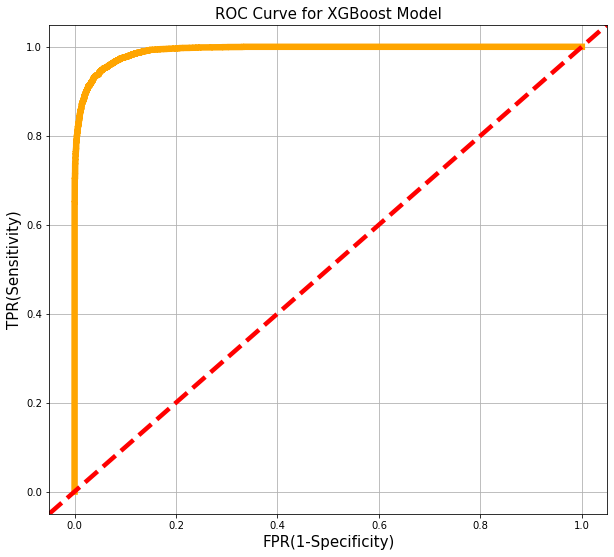

AUC Score for XGBoost Model for resampled test data : 
0.9911896848939327 

The Cross Entropy score of XGBoost Model :  1.8754996456368063 

Mean Score :  0.9453642714751995
Bias error :  5.4635728524800475
Variance error :  0.26113486446281947 

---------------------------------------------------------------------------------------------------------------------------- 



In [23]:
def BankPrediction_XGBoostModel(fin_model):
        X_new=X[['education_high.school', 'day_of_week_tue', 'day_of_week_thu', 
                             'day_of_week_mon', 'month_may', 'contact_telephone', 'loan_yes', 
                             'housing_yes', 'default_unknown', 'education_university.degree', 
                             'day_of_week_wed', 'education_basic.9y', 'marital_single', 
                             'marital_married', 'job_technician', 'poutcome_success', 'previous', 
                             'cons.price.idx', 'age', 'cons.conf.idx', 'nr.employed', 
                             'duration', 'job_blue-collar', 'campaign']]
        Y=bank_df['y']
        smt=SMOTE(sampling_strategy=0.95,random_state=10)
        Xnew_res, Y_res = smt.fit_resample(X_new,Y)
        XRes_train,XRes_test,YRes_train,YRes_test=train_test_split(Xnew_res,Y_res,test_size=0.2,random_state=10)
        plt.figure(figsize=(10,9))
        Res_model=fin_model.fit(XRes_train,YRes_train)
        YRespred_train=Res_model.predict(XRes_train)
        YRespred_test=Res_model.predict(XRes_test)
        YRespred_test_prob=Res_model.predict_proba(XRes_test)
        print('Overall accuracy of XGBoost Model for resampled train data : ',
        np.round(accuracy_score(YRes_train,YRespred_train),2)*100)
        print('Overall accuracy of XGBoost Model for resampled test data : ',
        np.round(accuracy_score(YRes_test,YRespred_test),2)*100,'\n')
        confusion_mat=confusion_matrix(YRes_test,YRespred_test)
        tn = confusion_mat[0,0]
        tp = confusion_mat[1,1]
        fp = confusion_mat[0,1]
        fn = confusion_mat[1,0]
        print('Confusion Matrix for XGBoost Model Model : ')
        print(confusion_mat,'\n')
        Sensitivity=((tp/(tp+fn))*100)
        print('Sensitivity : ',np.round(Sensitivity,2))
        Specificity=((tn/(tn+fp))*100)
        print('Specificity : ',np.round(Specificity,2),'\n')
        print('Classification report of XGBoost Model for resampled train data : ')
        print('-------------------------------------------------------------------------------','\n')
        print(classification_report(YRes_train,YRespred_train),'\n')
        print('Classification report of XGBoost Model for resampled test data : ')
        print('----------------------------------------------------------------','\n')
        print(classification_report(YRes_test,YRespred_test),'\n')
        fpr,trp,th=roc_curve(YRes_test,YRespred_test_prob[:,1])
        plt.plot(fpr,trp,color='orange',linewidth=6.5)
        plt.xlim([-0.05,1.05])
        plt.ylim([-0.05,1.05])
        plt.grid()
        plt.title('ROC Curve for XGBoost Model',fontsize=15)
        plt.xlabel('FPR(1-Specificity)',fontsize=15)
        plt.ylabel('TPR(Sensitivity)',fontsize=15)
        plt.plot([-0.05,1.05],[-0.05,1.05],'--r',linewidth=4.5)
        plt.show()
        print('AUC Score for XGBoost Model for resampled test data : ')
        print(roc_auc_score(YRes_test,YRespred_test_prob[:,1]),'\n')
        cross_entropy=log_loss(YRes_test,YRespred_test)
        print('The Cross Entropy score of XGBoost Model : ',cross_entropy,'\n')
        k=KFold(n_splits=10,shuffle=True, random_state=10)
        scores=cross_val_score(estimator=fin_model,X=XRes_train,y=YRes_train,cv=k,scoring='accuracy')
        print("Mean Score : ",np.mean(scores))
        print("Bias error : ",(1-np.mean(scores))*100)
        print("Variance error : ",(np.std(scores)/np.mean(scores))*100,'\n')
        print('----------------------------------------------------------------------------------------------------------------------------','\n')
fin_model=XGBClassifier(eval_metric='logloss')
BankPrediction_XGBoostModel(fin_model)